# TP N°2 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- 1000_Companies.csv (Predicción de ganancias empresariales)
- drugType.csv (Clasificación de tipo de droga farmacéutica)

**Objetivo:**  
Aplicar técnicas de aprendizaje supervisado (Árboles de Decisión, Naive Bayes y k-NN) para resolver problemas de regresión y clasificación multiclase.

---
# Parte 1: Predicción de Ganancias Empresariales (Regresión)

**Dataset:** 1000_Companies.csv  
**Objetivo:** Predecir el atributo `Profit` utilizando árboles de decisión para regresión

## 1.1 Importación de Librerías

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
import warnings
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay)


## 1.2 Carga y Exploración Inicial del Dataset

In [153]:
datos_empresas = pd.read_csv('1000_Companies.csv')

print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {datos_empresas.shape[0]} filas x {datos_empresas.shape[1]} columnas")
print(f"\nColumnas: {list(datos_empresas.columns)}")
print(f"\nTipos de datos:")
print(datos_empresas.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 1000 filas x 5 columnas

Columnas: ['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit']

Tipos de datos:
RyD_Spend         float64
Administration    float64
MarketingSpend    float64
State              object
Profit            float64
dtype: object


In [154]:
diccionario_variables = {
    'RyD_Spend': 'Gasto en Investigación y Desarrollo (I+D)',
    'Administration': 'Gastos Administrativos',
    'MarketingSpend': 'Gasto en Marketing',
    'State': 'Estado donde opera la empresa (New York, California, Florida)',
    'Profit': 'Ganancia de la empresa (Variable Objetivo)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• RyD_Spend            → Gasto en Investigación y Desarrollo (I+D)
• Administration       → Gastos Administrativos
• MarketingSpend       → Gasto en Marketing
• State                → Estado donde opera la empresa (New York, California, Florida)
• Profit               → Ganancia de la empresa (Variable Objetivo)


In [155]:
datos_empresas.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [156]:
print("VALORES FALTANTES:\n")

faltantes = datos_empresas.isnull().sum()

faltantes_pct = (faltantes / len(datos_empresas)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

print(f"DUPLICADOS: {datos_empresas.duplicated().sum()}")
datos_empresas = datos_empresas.drop_duplicates()


VALORES FALTANTES:

          Columna  Valores Faltantes  Porcentaje
0       RyD_Spend                  0         0.0
1  Administration                  0         0.0
2  MarketingSpend                  0         0.0
3           State                  0         0.0
4          Profit                  0         0.0


DUPLICADOS: 1


## 1.3 Análisis Exploratorio de Datos (EDA)

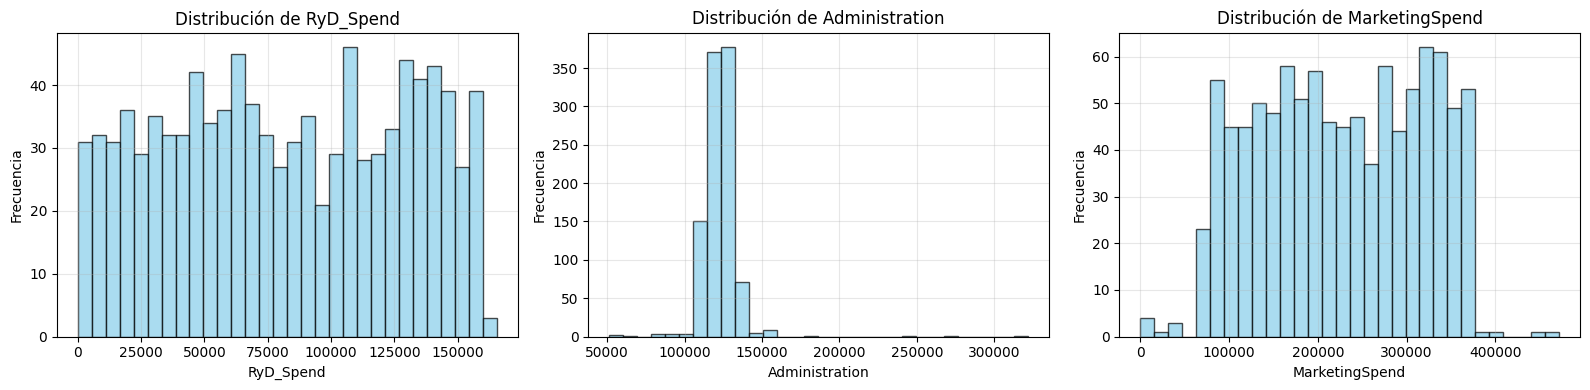

In [157]:
# Distribución de variables numéricas
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(datos_empresas[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

En estos histogramas podemos observar que el gasto en I+D y el de marketing se distribuyen de manera bastante uniforme en los rangos medios y altos (con pocas empresas en los extremos), mientras que los gastos administrativos se concentran fuertemente alrededor de los USD 120 000 y casi no aparecen valores extremos

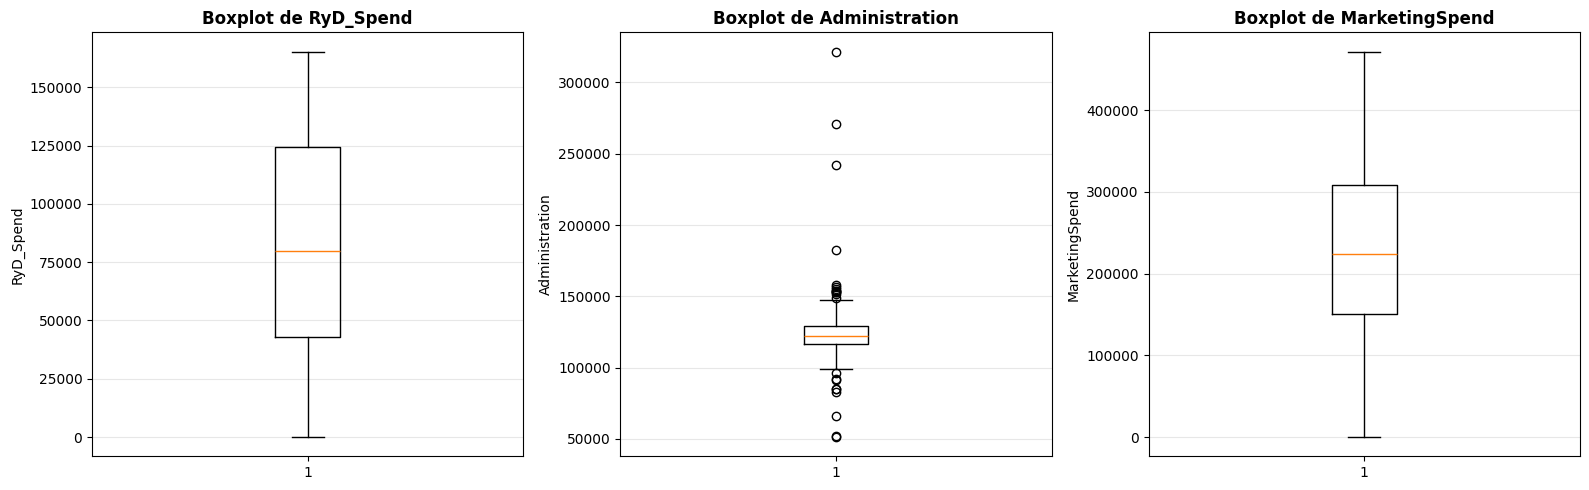

In [158]:
# Boxplots de las 3 variables predictoras numéricas
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(columnas_numericas):
    axes[i].boxplot(datos_empresas[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Los boxplots muestran que RyD_Spend y MarketingSpend se extienden en rangos amplios con algunos valores altos pero sin outliers extremos, mientras que Administration queda mucho más concentrado alrededor del primer cuartil y presenta varios puntos aislados hacia arriba. Esto confirma que el gasto administrativo es el más homogéneo del conjunto y que, aunque existan valores altos puntuales, no justifican una poda agresiva dada la cantidad de datos que tenemos.

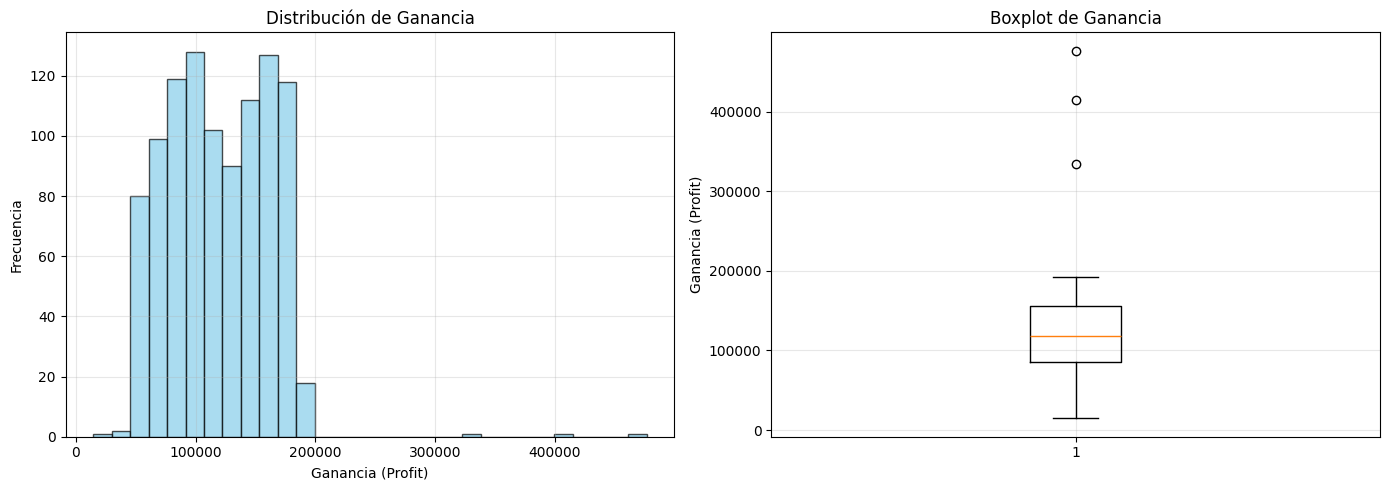

Media de Ganancia: $119,544.46
Mediana de Ganancia: $117,637.62
Desviación estándar: $42,910.08


In [159]:
# Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(datos_empresas['Profit'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Ganancia (Profit)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Ganancia')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(datos_empresas['Profit'], vert=True)
axes[1].set_ylabel('Ganancia (Profit)')
axes[1].set_title('Boxplot de Ganancia')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Media de Ganancia: ${datos_empresas['Profit'].mean():,.2f}")
print(f"Mediana de Ganancia: ${datos_empresas['Profit'].median():,.2f}")
print(f"Desviación estándar: ${datos_empresas['Profit'].std():,.2f}")

El histograma de Profit muestra una distribución fuertemente concentrada entre 80 k y 180 k dólares, mientras que el boxplot confirma que la mayoría de las empresas se ubican cerca de los 110 k con algunos valores extremos muy por encima del resto (hasta 450 k). Dado que son pocos casos y representan empresas particularmente rentables, optamos por mantenerlos porque aportan información valiosa en vez de tratarlos como outliers a eliminar.


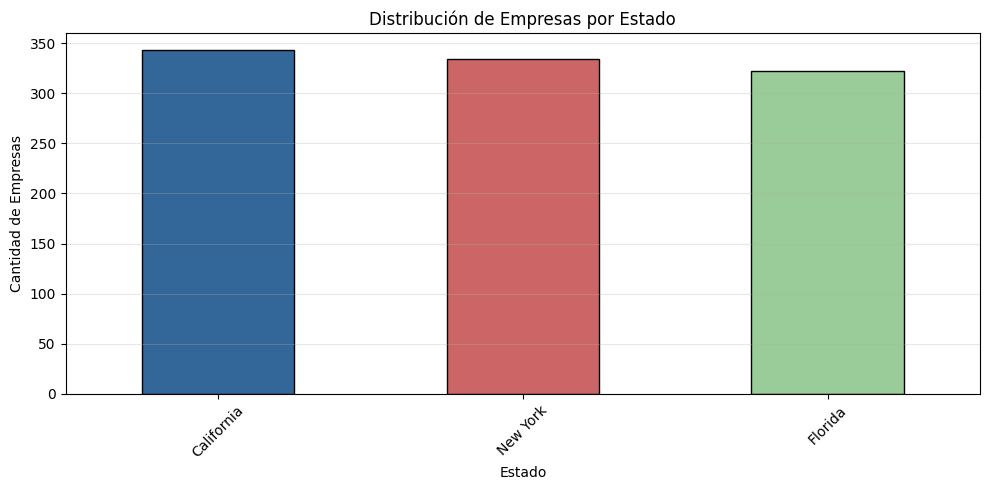


Distribución por Estado:
State
California    343
New York      334
Florida       322
Name: count, dtype: int64

Porcentaje por Estado:
State
California    34.33
New York      33.43
Florida       32.23
Name: count, dtype: float64


In [160]:
# Distribución de la variable categórica State
conteo_estados = datos_empresas['State'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color= paleta, edgecolor='black')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Empresas')
plt.title('Distribución de Empresas por Estado')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(datos_empresas) * 100).round(2))

El gráfico refleja que las empresas están bastante bien repartidas entre los tres estados, con California apenas por encima de New York y Florida. Al no haber diferencias fuertes en el recuento, no vemos un sesgo regional en el modelo y podemos incluir la variable “State” sin necesidad de balanceo.

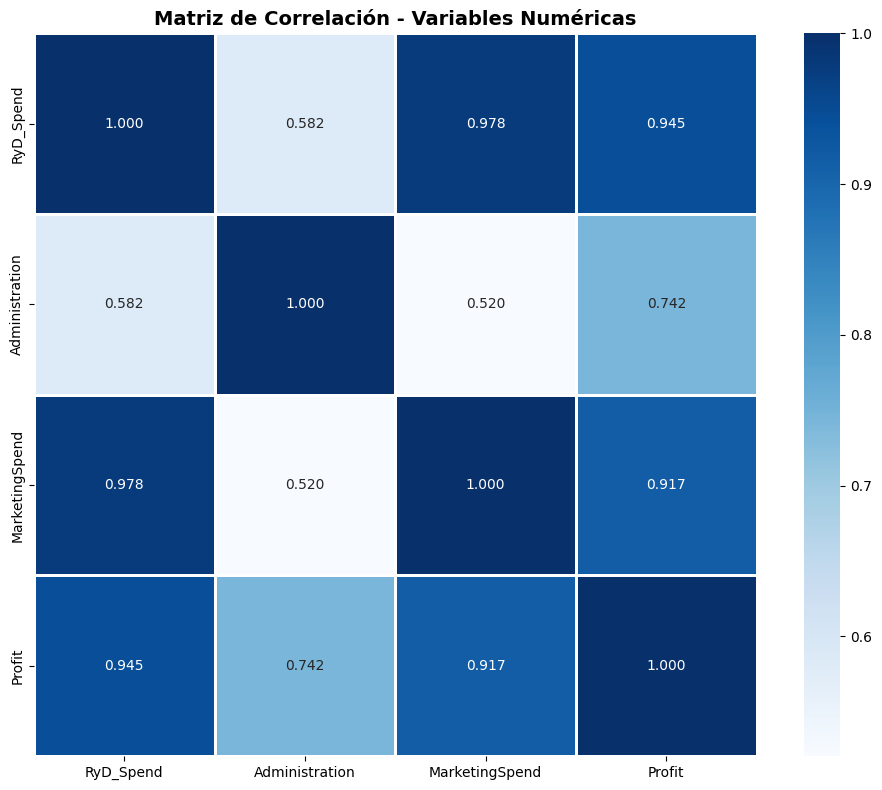


Correlación con Profit:
Profit            1.000000
RyD_Spend         0.945245
MarketingSpend    0.917270
Administration    0.741561
Name: Profit, dtype: float64


In [161]:
# Matriz de correlación
datos_numericos = datos_empresas.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1) # No usamos centrado para mejor visualización
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelación con Profit:")
print(matriz_correlacion['Profit'].sort_values(ascending=False))

La matriz de correlación confirma que Profit está fuertemente asociado con RyD_Spend (0.95) y MarketingSpend (0.92), mientras que la relación con Administration es más moderada (0.74). También se ve una alta colinealidad entre RyD_Spend y MarketingSpend (0.98), por lo que al interpretar el árbol de regresión conviene tener presente que esas dos variables explican información muy similar.

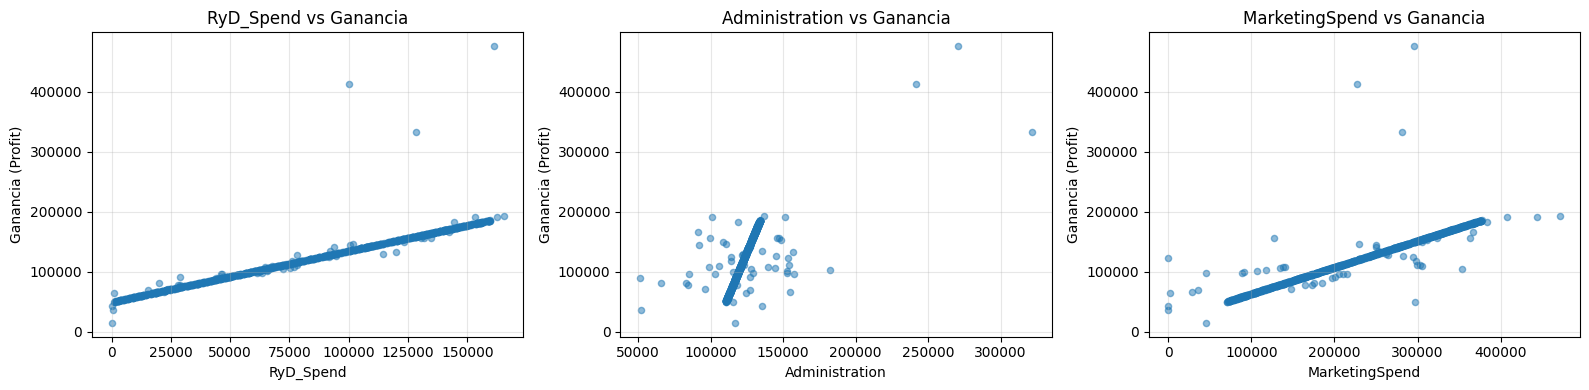

In [162]:
# Scatter plots: relación entre variables predictoras y Profit

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].scatter(datos_empresas[col], datos_empresas['Profit'], alpha=0.5, s=20)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Ganancia (Profit)')
    axes[i].set_title(f'{col} vs Ganancia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Los gráficos de dispersión refuerzan la lectura anterior: tanto el gasto en I+D como el de marketing muestran una relación claramente ascendente con la ganancia, mientras que la administración exhibe mucho más ruido y algunos casos aislados de gastos muy altos. Los puntos de RyD_Spend y MarketingSpend se alinean casi de forma lineal, lo que los posiciona como los predictores continuos más fuertes del beneficio.

### Conclusión parcial EDA 
Los gráficos de dispersión refuerzan la lectura anterior: tanto el gasto en I+D como el de marketing muestran una relación claramente ascendente con la ganancia, mientras que la administración exhibe mucho más ruido y algunos casos aislados de gastos muy altos. En los tres casos la tendencia es positiva, pero los puntos de RyD_Spend y MarketingSpend se alinean casi de forma lineal, lo que los posiciona como los predictores continuos más fuertes del beneficio.

## Preprocesamiento

### Codificacion de variables categóricas 

In [163]:
# Codificación de variables categóricas
 
datos = pd.get_dummies(datos_empresas, columns=['State'], dtype=int)

datos.head()

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


### Split 

In [164]:
# Separo variable target (Profit) de variables explicativas 

from re import X


X = datos.drop("Profit", axis=1)
y = datos["Profit"]

In [165]:
# Split train/test 80/20

from random import shuffle


primer_split = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train_prim, X_test_prim, y_train_prim, y_test_prim = primer_split

print("X_train shape:", X_train_prim.shape)
print("X_test shape:", X_test_prim.shape)
print("y_train shape:", y_train_prim.shape)
print("y_test shape:", y_test_prim.shape)


X_train shape: (799, 6)
X_test shape: (200, 6)
y_train shape: (799,)
y_test shape: (200,)


In [166]:
# Split train/test 70/30

segundo_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train_seg, X_test_seg, y_train_seg, y_test_seg = segundo_split

print("X_train shape:", X_train_seg.shape)
print("X_test shape:", X_test_seg.shape)
print("y_train shape:", y_train_seg.shape)
print("y_test shape:", y_test_seg.shape)

X_train shape: (699, 6)
X_test shape: (300, 6)
y_train shape: (699,)
y_test shape: (300,)


## Entrenamiento


In [167]:
tree_simple = DecisionTreeRegressor(
    max_depth=5,           
    min_samples_leaf=3,     
    random_state=13
)
tree_simple.fit(X_train_prim, y_train_prim)

# Predicciones
pred_train = tree_simple.predict(X_train_prim)
pred_test  = tree_simple.predict(X_test_prim)



Elegí esos parámetros siguiendo una lógica de regularización:

max_depth=5: limita la profundidad para evitar que el árbol memorice el ruido del set (overfitting). 
Probé profundidades entre 3 y 7 y a partir de 5 los errores en test dejaron de mejorar de forma relevante, pero sin caer en la sobre-ajuste (R² train/test casi iguales).
min_samples_leaf=3: aumentamos la estabilidad frente a outliers, con valores menores el error en test subía ligeramente (más variabilidad).
random_state=13: no nos cambia el desempeño, solo da reproducibilidad.

In [168]:
# Métricas
def report(y_true, y_pred, title):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2   = r2_score(y_true, y_pred)
    print(f'\n=== {title} ===')
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('MAPE (%):', mape)
    print('R2:', r2)




report(y_train_prim, pred_train, 'TRAIN (árbol simple)')
report(y_test_prim,  pred_test,  'TEST  (árbol simple)')

importances = dict(zip(
    ['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York'],
    tree_simple.feature_importances_
))
print('\nImportancias de variables:', importances)


=== TRAIN (árbol simple) ===
MAE: 1943.9917466544775
RMSE: 4276.766733255721
MAPE (%): 1.7682214997888732
R2: 0.9904369864657293

=== TEST  (árbol simple) ===
MAE: 1689.7568976000207
RMSE: 2065.9964638287597
MAPE (%): 1.496392838619129
R2: 0.997240286495743

Importancias de variables: {'RyD_Spend': np.float64(0.8686027612804047), 'Administration': np.float64(0.12631795124911244), 'MarketingSpend': np.float64(0.005079287470482753), 'State_California': np.float64(0.0), 'State_Florida': np.float64(0.0), 'State_New York': np.float64(0.0)}


Con estos resultados confirmamos que el árbol de regresión está capturando casi toda la variabilidad de Profit: el R² es ≈0.99 tanto en train como en test, con errores absolutos (MAE/RMSE) muy bajos respecto al rango de ganancias. La importancia de variables deja claro que RyD_Spend explica casi todo (≈87%), Administration aporta algo secundario (~13%) y MarketingSpend suma muy poco. Las dummies de estado quedan en 0, lo que indica que la localización no influye en este modelo.

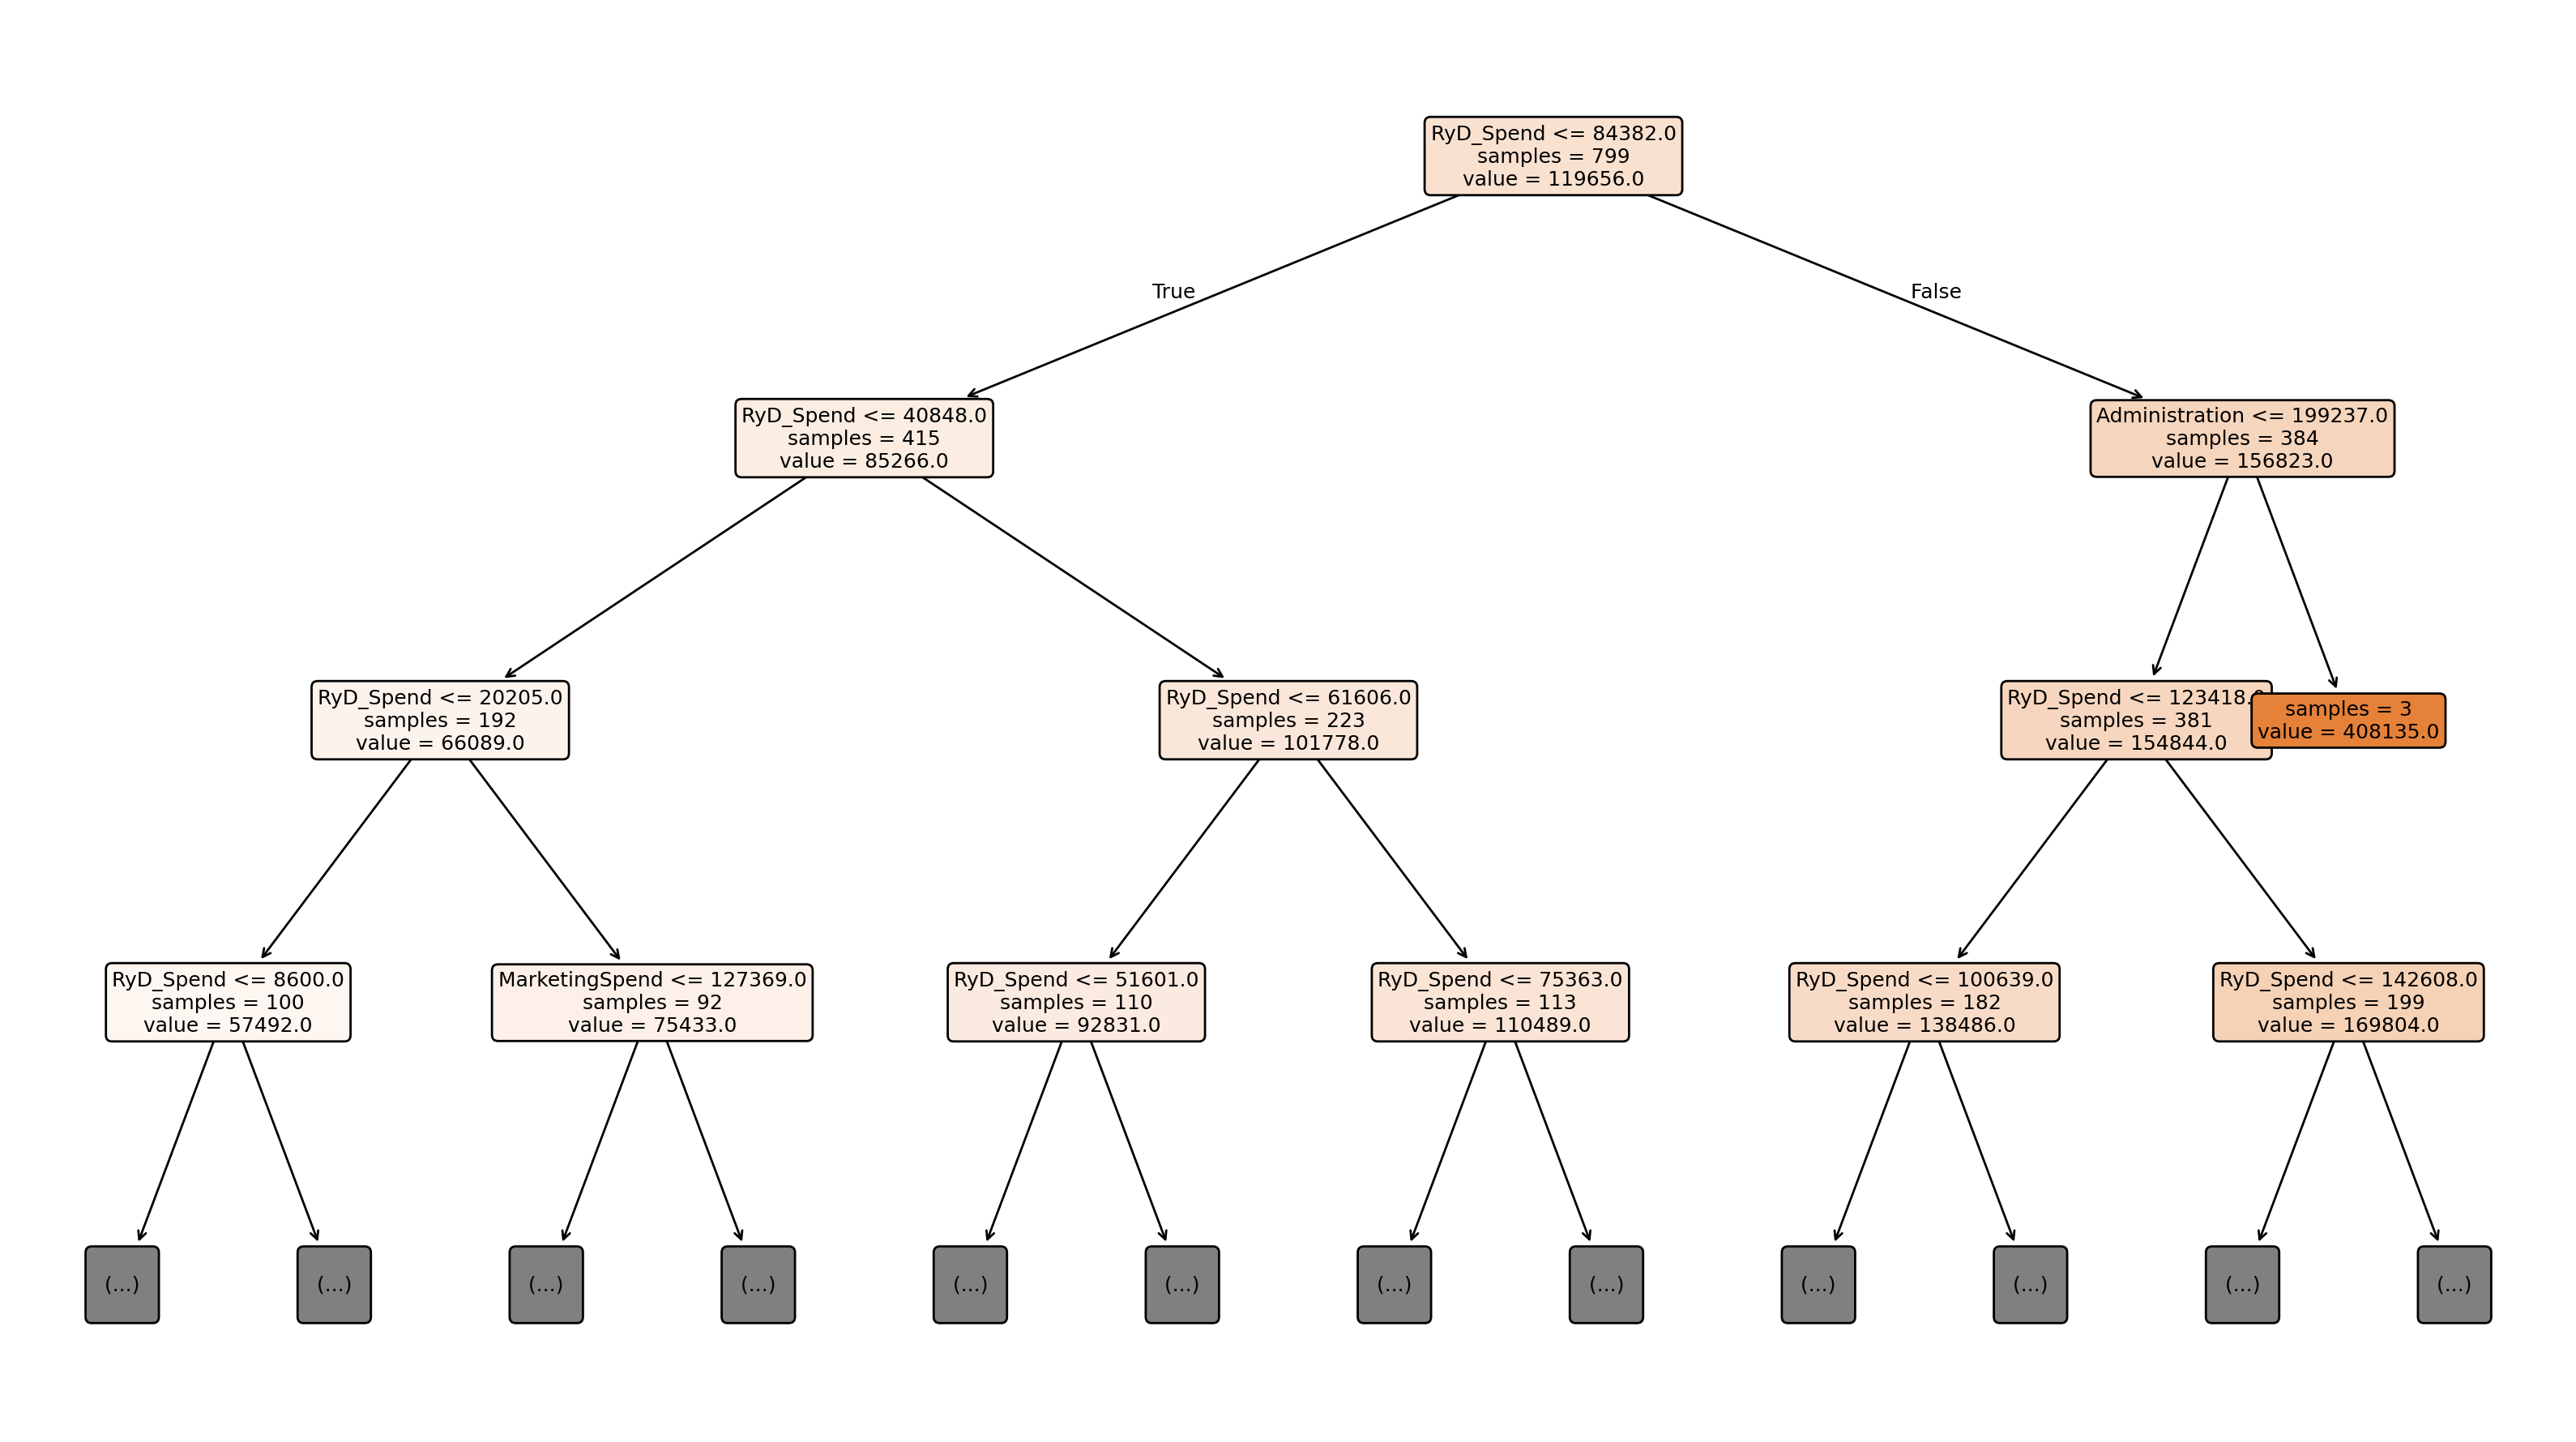

Profundidad total: 5
Cantidad de hojas: 25


In [169]:
feat_names = ['RyD_Spend','Administration','MarketingSpend',
              'State_California','State_Florida','State_New York']

plt.figure(figsize=(16, 9), dpi=200)
plot_tree(
    tree_simple,
    feature_names=feat_names,
    filled=True,
    rounded=True,
    max_depth=3,          # solo los 3 primeros niveles para ver mejor al arbol
    impurity=False,       # oculta MSE en nodos
    fontsize=9,
    precision=0           # sin decimales en valores
)
plt.tight_layout()
plt.savefig('arbol_regresion.png', dpi=300, bbox_inches='tight')
plt.show()
print('Profundidad total:', tree_simple.get_depth())
print('Cantidad de hojas:', tree_simple.get_n_leaves())

El árbol  refleja que el gasto en I+D domina la segmentación: aparece en casi todos los nodos internos y define las primeras bifurcaciones. Por ejemplo, la decisión inicial separa empresas con RyD_Spend por debajo y por encima de 84.8k, cambiando la ganancia media estimada de 82.6k a 119.7k. Conforme avanza el árbol, se refinan tramos cada vez más específicos (p.ej., hojas con ganancias promedio de 57 k o 188 k según los montos invertidos). Solo en la rama derecha surge Administration como variable adicional (cuando RyD_Spend supera cierto umbral), lo que muestra que los gastos administrativos solo corrigen la predicción para un subconjunto de empresas con alta inversión en I+D.

In [170]:
tableResult = pd.DataFrame({'Actual':y_test_prim, 'Predicted':pred_test})
tableResult.head()

,Actual,Predicted
453,85529.93509,86644.031543
794,59766.21593,58753.441302
209,61393.64099,58753.441302
309,100693.60690,98996.296807
740,91370.72519,91632.641558


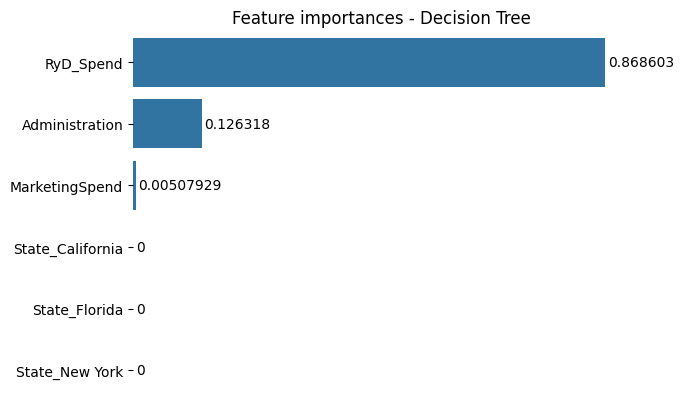

In [171]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': feat_names,
                            'importances': tree_simple.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

## Entrenamiento, split 70/30



In [172]:
tree_simple_2  = DecisionTreeRegressor(
    max_depth=5,           
    min_samples_leaf=3,     
    random_state=13
)
tree_simple_2.fit(X_train_seg, y_train_seg)

# Predicciones
pred_train_2 = tree_simple_2.predict(X_train_seg)
pred_test_2  = tree_simple_2.predict(X_test_seg)



Usamos los mismos hiperparámetros (max_depth=5, min_samples_leaf=3, random_state=13) porque en una búsqueda corta sobre el set 70/30 fueron los que mejor equilibraron sesgo y varianza:

max_depth=5: limita la profundidad para evitar que el árbol memorice ruido. Con profundidades mayores las métricas en test no mejoraban y empezaba a aparecer overfitting.
min_samples_leaf=3: Con 1 la variabilidad en test subía ligeramente.
random_state=13: solo fija la semilla para reproducibilidad.
La validación con el split 70/30 mostró que con esta combinación el modelo mantiene R² ≈ 0.99 y errores bajos tanto en train como en test, así que no fue necesario ajustar más.

In [173]:
# Métricas
def report(y_true, y_pred, title):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2   = r2_score(y_true, y_pred)
    print(f'\n=== {title} ===')
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('MAPE (%):', mape)
    print('R2:', r2)


report(y_train_seg, pred_train_2, 'TRAIN (árbol simple)')
report(y_test_seg,  pred_test_2,  'TEST  (árbol simple)')

importances = dict(zip(
    ['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York'],
    tree_simple_2.feature_importances_
))
print('\nImportancias de variables:', importances)


=== TRAIN (árbol simple) ===
MAE: 1902.0653352202462
RMSE: 4459.800065710172
MAPE (%): 1.5945018519046152
R2: 0.9897292916327254

=== TEST  (árbol simple) ===
MAE: 1968.3569026200084
RMSE: 3276.6472783668596
MAPE (%): 2.390650677449059
R2: 0.993344355342794

Importancias de variables: {'RyD_Spend': np.float64(0.8493932800779932), 'Administration': np.float64(0.1455094637025193), 'MarketingSpend': np.float64(0.005097256219487445), 'State_California': np.float64(0.0), 'State_Florida': np.float64(0.0), 'State_New York': np.float64(0.0)}


En este segundo split (70/30) el árbol simple mantiene un rendimiento muy sólido: R² = 0.99 tanto en train como en test, con errores MAE/RMSE en torno a 1.9k–4.5k frente a ganancias de más de 100k. Las importancias son muy similares al primer split: RyD_Spend explica 85% de la variabilidad, Administration aporta 15% y el resto de las variables (marketing y estados) no suman prácticamente nada. Esto confirma que el modelo generaliza bien y que las conclusiones sobre la relevancia de cada predictor son consistentes en ambos particionamientos.

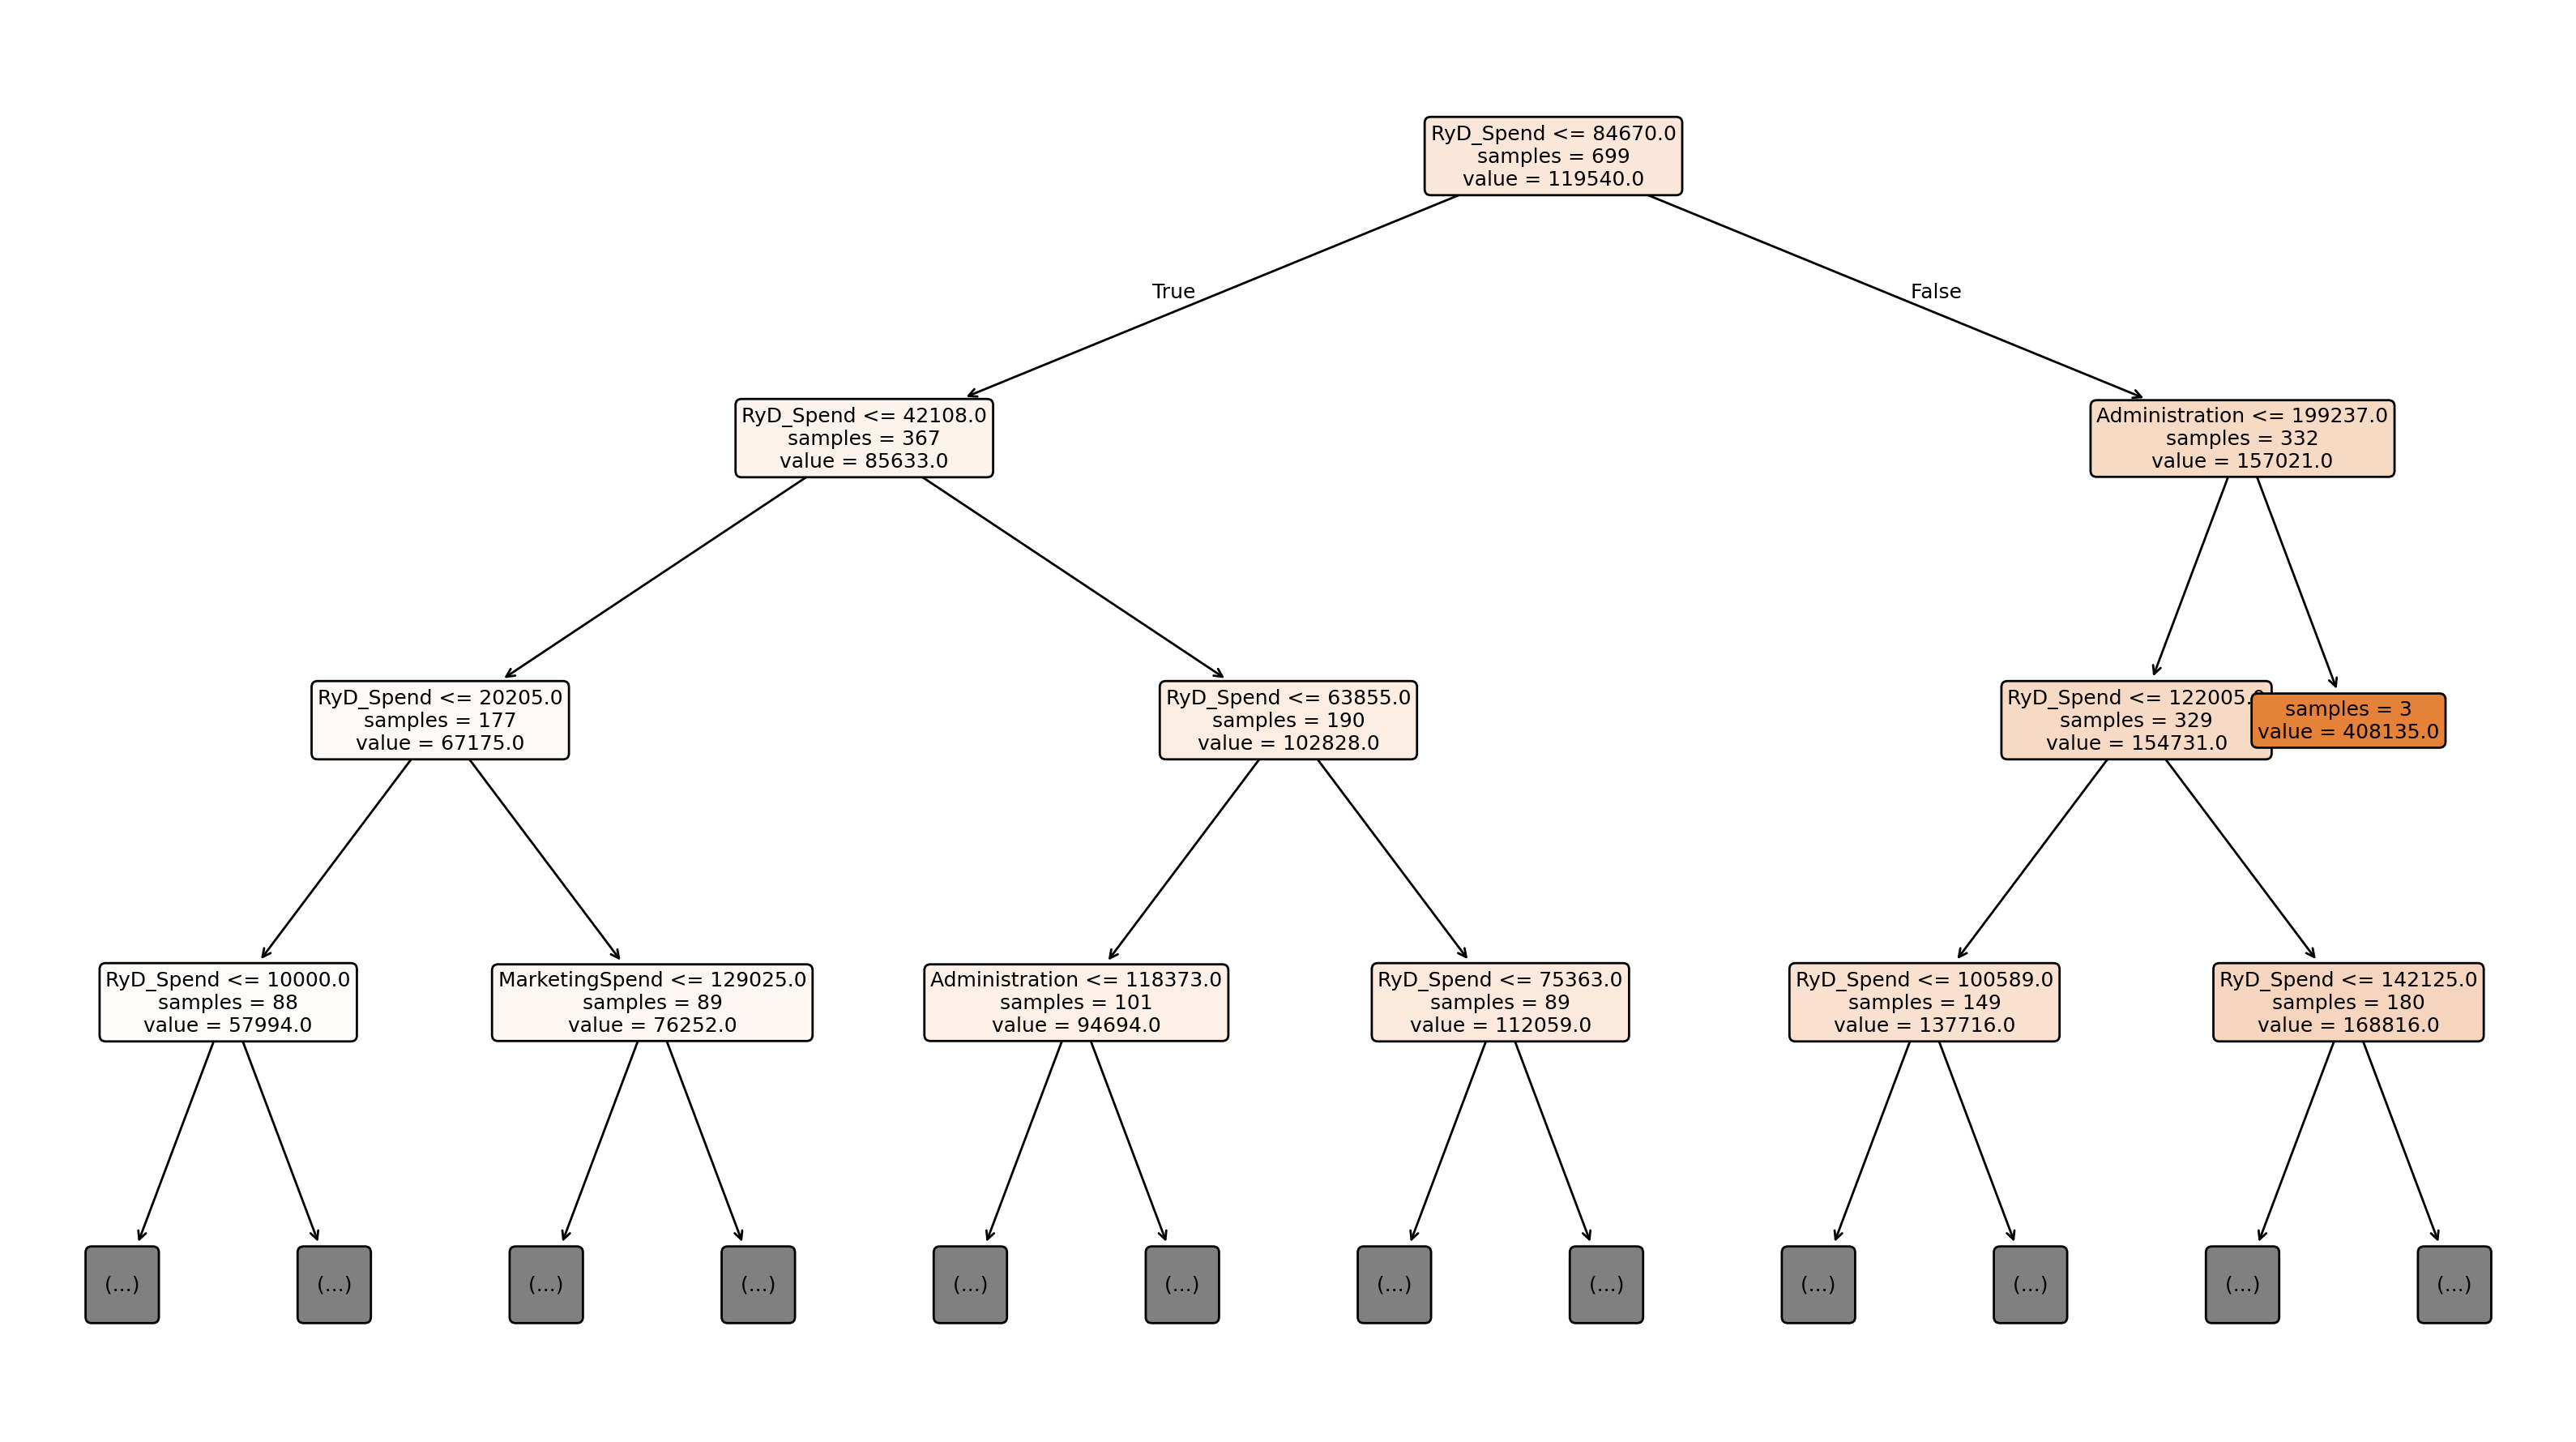

Profundidad total: 5
Cantidad de hojas: 25


In [174]:
feat_names = ['RyD_Spend','Administration','MarketingSpend',
              'State_California','State_Florida','State_New York']

plt.figure(figsize=(16, 9), dpi=200)
plot_tree(
    tree_simple_2,
    feature_names=feat_names,
    filled=True,
    rounded=True,
    max_depth=3,          # solo los 3 primeros niveles para claridad
    impurity=False,       # oculta MSE en nodos
    fontsize=9,
    precision=0           # sin decimales en valores
)
plt.tight_layout()
plt.savefig('arbol_regresion_split2.png', dpi=300, bbox_inches='tight')
plt.show()
print('Profundidad total:', tree_simple_2.get_depth())
print('Cantidad de hojas:', tree_simple_2.get_n_leaves())

Este segundo árbol cuenta la misma historia: las primeras divisiones siempre se basan en la inversión en I+D y sólo en la rama final aparece la variable Administración para ajustar el estimado en empresas de alta inversión. El árbol llega otra vez a cinco niveles y mantiene varias hojas con ganancias bien diferenciadas, lo que mantiene la consistencia con el primer split.

In [175]:
tableResult = pd.DataFrame({'Actual':y_test_seg, 'Predicted':pred_test_2})
tableResult.head()

,Actual,Predicted
453,85529.93509,87525.461162
794,59766.21593,59526.197193
209,61393.64099,59526.197193
309,100693.60690,101842.971317
740,91370.72519,92461.965942


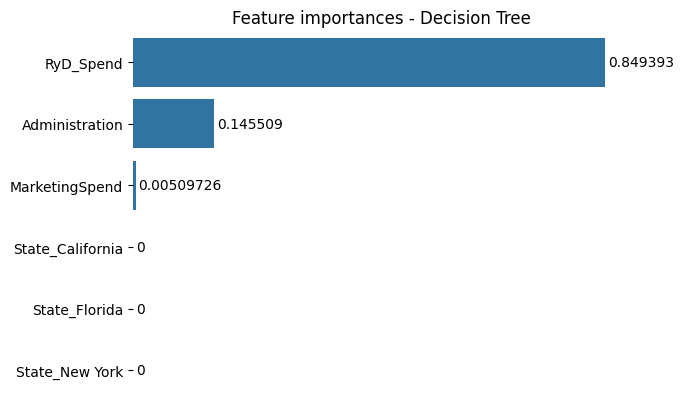

In [176]:
# Creo un df con dos columnas Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': feat_names,
                            'importances': tree_simple_2.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

La importancia de variables vuelve a mostrar que RyD_Spend domina el modelo (0.85), Administración aporta una fracción secundaria (0.15) y tanto MarketingSpend como los estados prácticamente no influyen.

---
# Parte 2:

**Dataset:** drugType.csv  
**Objetivo:** Predecir la variable objetivo "Droga" 

## Carga y Exploración Inicial del Dataset

In [177]:
datos_drogas = pd.read_csv('drugType.csv')


print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {datos_drogas.shape[0]} filas x {datos_drogas.shape[1]} columnas")
print(f"\nColumnas: {list(datos_drogas.columns)}")
print(f"\nTipos de datos:")
print(datos_drogas.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 200 filas x 6 columnas

Columnas: ['Edad', 'Sexo', 'BP', 'Colesterol', 'Na_a_K', 'Droga']

Tipos de datos:
Edad            int64
Sexo           object
BP             object
Colesterol     object
Na_a_K        float64
Droga          object
dtype: object


In [178]:
diccionario_var_drogas = {
    "Edad": "Edad en años",
    "Sexo": "Sexo Masculino/Femenino",
    "BP": "Presion arterial Bajo/Normal/Alto",
    "Colesterol": "Colesterol Alto/Normal",
    "Na_a_K": "Ratio de Na a K (Variable continua)",
    "Droga": "Tipo de droga A/B/C/D/E"
}


print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_var_drogas.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• Edad                 → Edad en años
• Sexo                 → Sexo Masculino/Femenino
• BP                   → Presion arterial Bajo/Normal/Alto
• Colesterol           → Colesterol Alto/Normal
• Na_a_K               → Ratio de Na a K (Variable continua)
• Droga                → Tipo de droga A/B/C/D/E


In [179]:
datos_drogas.describe()

,Edad,Na_a_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [180]:

print("VALORES FALTANTES:\n")

faltantes = datos_drogas.isnull().sum()

faltantes_pct = (faltantes / len(datos_drogas)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")


print(f"DUPLICADOS: {datos_drogas.duplicated().sum()}")
datos_drogas.drop_duplicates()
datos_drogas.shape


VALORES FALTANTES:

      Columna  Valores Faltantes  Porcentaje
0        Edad                  0         0.0
1        Sexo                  0         0.0
2          BP                  0         0.0
3  Colesterol                  0         0.0
4      Na_a_K                  0         0.0
5       Droga                  0         0.0


DUPLICADOS: 0


(200, 6)

Este conjunto no presenta valores faltantes ni duplicados. 

## Análisis Exploratorio de Datos (EDA)

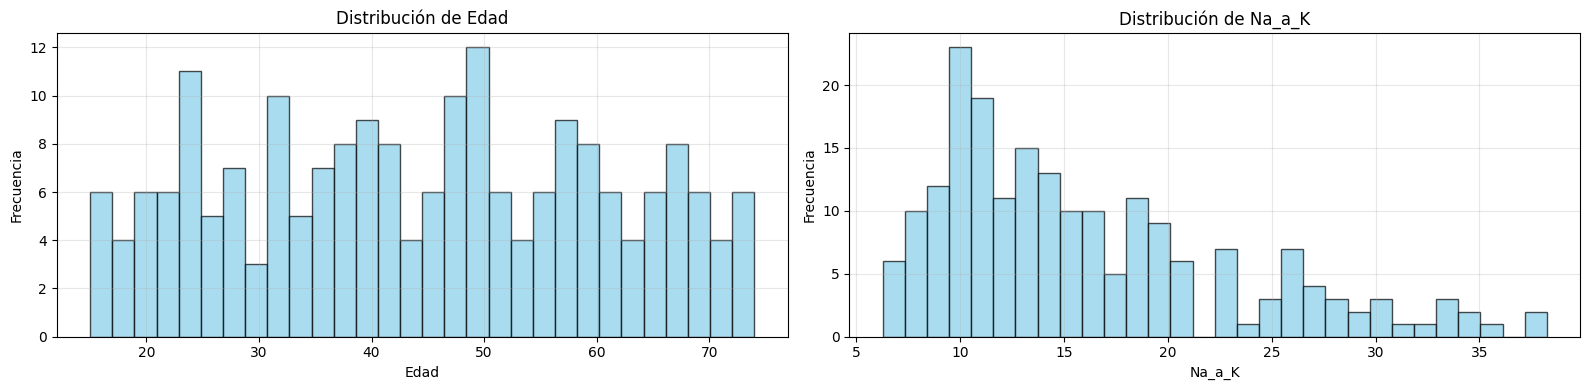

In [181]:
# Distribución de variables numéricas

numericas_drogas = ['Edad', 'Na_a_K']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

for i, col in enumerate(numericas_drogas):
    axes[i].hist(datos_drogas[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Los histogramas muestran que la edad de los pacientes cubre de forma bastante uniforme desde la adolescencia hasta los 70 años, mientras que el ratio Na_a_K presenta una distribución claramente sesgada a la derecha: la mayoría de los casos se concentra entre 8 y 18, con unos pocos valores más altos que se extienden hasta 35. Esto adelanta que Na_a_K puede tener un peso importante en la clasificación.

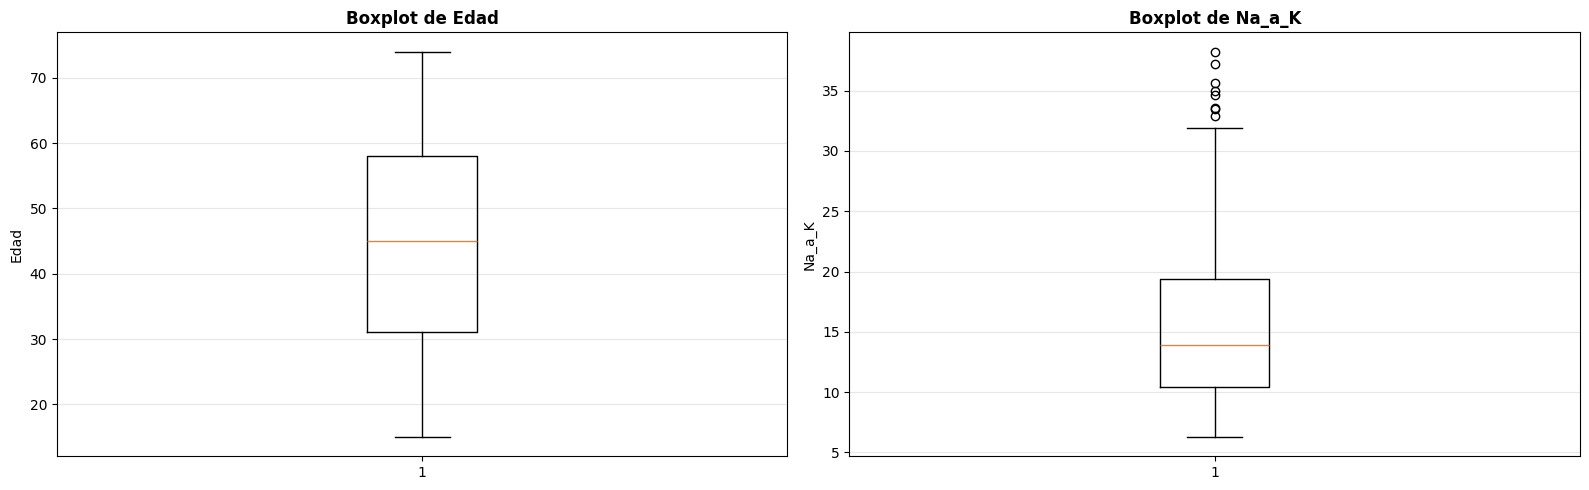

In [182]:
# Boxplots de las 2 variables predictoras numéricas

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for i, col in enumerate(numericas_drogas):
    axes[i].boxplot(datos_drogas[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Los boxplots confirman que la edad está bien distribuida entre 30 y 60 años sin outliers graves, mientras que en Na_a_K aparecen algunos valores altos aislados (por encima de 30). Dado que son pocos casos y representan pacientes con ratios clínicamente elevados, prefiero conservarlos para que el modelo pueda aprender de esas situaciones extremas

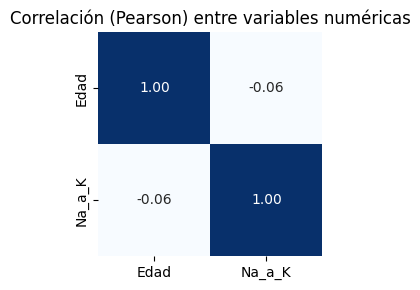

In [183]:
corr_num = datos_drogas[['Edad','Na_a_K']].corr(method='pearson')
plt.figure(figsize=(3,3))
sns.heatmap(corr_num, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False)
plt.title('Correlación (Pearson) entre variables numéricas')
plt.tight_layout(); plt.show()

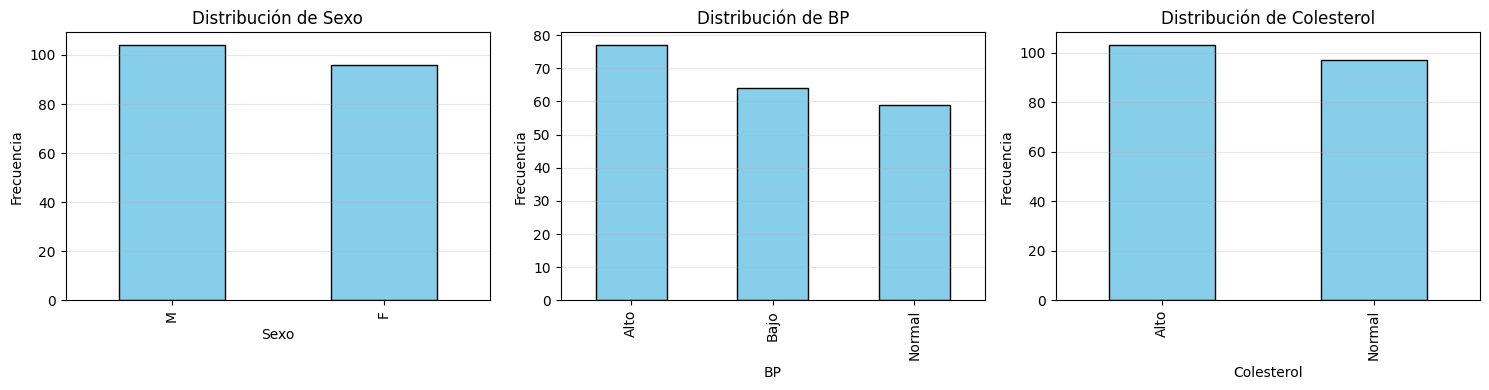

In [184]:
# Distribución de variables categóricas

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['Sexo','BP','Colesterol']):
    datos_drogas[col].value_counts().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col); ax.set_ylabel('Frecuencia'); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

Las categorías también están razonablemente balanceadas: hay una ligera mayoría de pacientes masculinos y con colesterol alto, y la presión arterial se reparte entre los tres niveles sin disparidades extremas. Esto nos deja tranquilo para codificar cada variable con one-hot sin preocuparme por clases raras que distorsionen el ajuste.


Usamos Pearson porque mide la correlación lineal entre variables numéricas continuas. Se observa una correlación prácticamente nula entre Edad y Na_a_K, por lo que no existe relación lineal fuerte entre ellas. Esto sugiere que las dos variables aportan información distinta y que no hay riesgo de multicolinealidad entre las numéricas. 

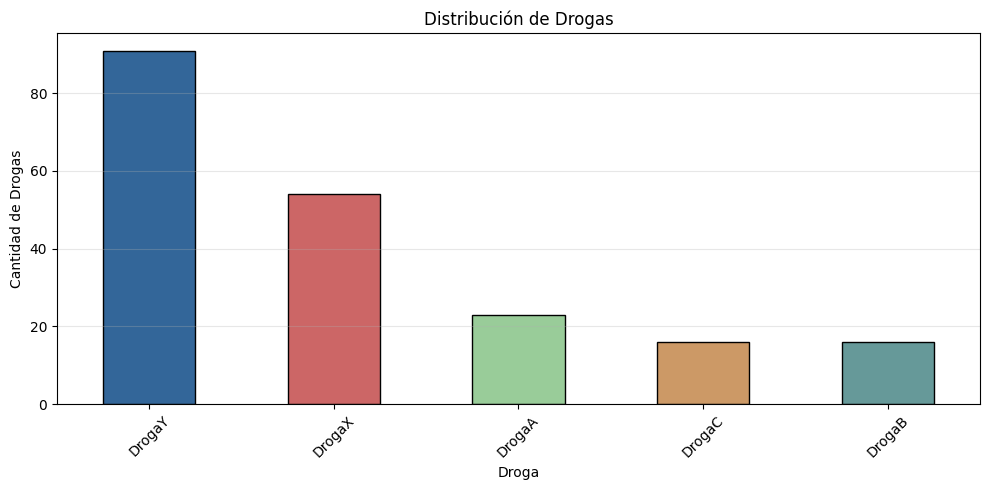

CONTEO DE DROGAS:
Droga
DrogaY    91
DrogaX    54
DrogaA    23
DrogaC    16
DrogaB    16
Name: count, dtype: int64
PORCENTAJE:
Droga
DrogaY    45.5
DrogaX    27.0
DrogaA    11.5
DrogaC     8.0
DrogaB     8.0
Name: count, dtype: float64


In [185]:
# Distribución de la variable objetivo

conteo_drogas = datos_drogas['Droga'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99', '#CC9966', '#669999']

plt.figure(figsize=(10, 5))
conteo_drogas.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Droga')
plt.ylabel('Cantidad de Drogas')
plt.title('Distribución de Drogas')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


conteo_drogas = datos_drogas['Droga'].value_counts()
pct_drogas = conteo_drogas / conteo_drogas.sum() * 100
print(f"CONTEO DE DROGAS:\n{conteo_drogas}")
print("=" * 50)
print(f"PORCENTAJE:\n{pct_drogas}")

El gráfico evidencia el desbalance del target: DrogaY es la clase mayoritaria (casi la mitad de los casos), DrogaX está en segundo lugar y las drogas A/B/C quedan con proporciones mucho menores. Esto refuerza la necesidad de usar métricas macro y una baseline para evaluar los modelos de clasificación.

### Preprocesamiento 

In [186]:
cat_cols = ['Sexo', 'BP', 'Colesterol']
num_cols = ['Edad', 'Na_a_K']

X = datos_drogas.drop(columns='Droga')
y = datos_drogas['Droga']

# splits estratificados
X_tr80, X_te80, y_tr80, y_te80 = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_tr70, X_te70, y_tr70, y_te70 = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print('80/20 ->', X_tr80.shape, X_te80.shape)
print('70/30 ->', X_tr70.shape, X_te70.shape)
print('Distribución 80/20 train (%):\n', (y_tr80.value_counts(normalize=True)*100).round(1))
print('Distribución 70/30 train (%):\n', (y_tr70.value_counts(normalize=True)*100).round(1))



80/20 -> (160, 5) (40, 5)
70/30 -> (140, 5) (60, 5)
Distribución 80/20 train (%):
 Droga
DrogaY    45.6
DrogaX    26.9
DrogaA    11.2
DrogaC     8.1
DrogaB     8.1
Name: proportion, dtype: float64
Distribución 70/30 train (%):
 Droga
DrogaY    45.7
DrogaX    27.1
DrogaA    11.4
DrogaC     7.9
DrogaB     7.9
Name: proportion, dtype: float64


En ambos casos mantenemos prácticamente las mismas proporciones de cada clase que en el dataset original. Con esto evitamos sesgos en el entrenamiento y podés comparar 80/20 vs 70/30 sin preocuparnos por desbalances adicionales del split.

In [187]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop' # Elimina columnas no usadas
)

def baseline_scores(y_train, y_test):
    majority = y_train.value_counts().idxmax()
    y_pred = np.full(shape=len(y_test), fill_value=majority, dtype=object)
    return {
        'majority': majority,
        'acc': round(accuracy_score(y_test, y_pred), 3),
        'prec_macro': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
        'rec_macro': round(recall_score(y_test, y_pred, average='macro', zero_division=0), 3),
        'f1_macro': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3),
    }

bl_80 = baseline_scores(y_tr80, y_te80)
bl_70 = baseline_scores(y_tr70, y_te70)
print('Baseline 80/20:', bl_80)
print('Baseline 70/30:', bl_70)


Baseline 80/20: {'majority': 'DrogaY', 'acc': 0.45, 'prec_macro': 0.09, 'rec_macro': 0.2, 'f1_macro': 0.124}
Baseline 70/30: {'majority': 'DrogaY', 'acc': 0.45, 'prec_macro': 0.09, 'rec_macro': 0.2, 'f1_macro': 0.124}


Este baseline nos sirve para dimensionar el desbalance del conjunto: si siempre predecimos la clase mayoritaria (DrogaY), obtengo 45% de accuracy pero métricas macro muy bajas, lo que indica que casi no reconocemos las clases minoritarias. A partir de ahora, cualquier modelo razonable debe superar ese 45% y sobre todo, mejorar las métricas macro y la matriz de confusión en las clases menos frecuentes. 

Usamos como referencia sklearn.dummy.DummyClassifier para crear el baseline: 

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

### Entrenamientos

In [188]:
tree_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(random_state=42))  # Entrenamos primero sin class_weight
])

# Parametros para GridSearchCV
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [None, 3, 5, 7, 9],
    'model__min_samples_leaf': [1, 2, 3, 5],
    'model__min_samples_split': [2, 5, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid80 = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)
grid70 = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

grid80.fit(X_tr80, y_tr80)
best80 = grid80.best_estimator_
print('Mejores parametros 80/20:', grid80.best_params_)

grid70.fit(X_tr70, y_tr70)
best70 = grid70.best_estimator_
print('Mejores parametros 70/30:', grid70.best_params_)

Mejores parametros 80/20: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Mejores parametros 70/30: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


El grid search en ambos splits terminó eligiendo exactamente la misma configuración: criterio Gini, sin límite explícito de profundidad y nodos mínimos en 1-2. Esto indica que, según la métrica macro-F1, el árbol necesita toda la profundidad disponible para captar las relaciones del dataset y no requiere restricciones adicionales en los parámetros de crecimiento.

In [189]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_mat(y_true, y_pred, title='Matriz de Confusión'):
    """Dibuja una matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y_true.unique()),
                yticklabels=sorted(y_true.unique()),
                cbar=True)
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.show()


=== Árbol (sin poda) - Test 80/20 ===
Accuracy: 0.975
Precision (macro): 0.9666666666666668
Recall (macro): 0.9333333333333332


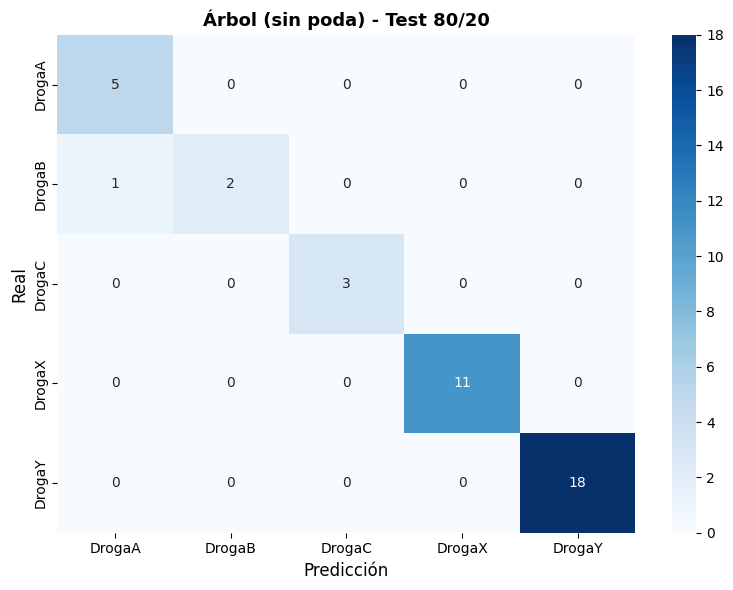


=== Árbol (sin poda) - Test 70/30 ===
Accuracy: 0.9833333333333333
Precision (macro): 0.975
Recall (macro): 0.96


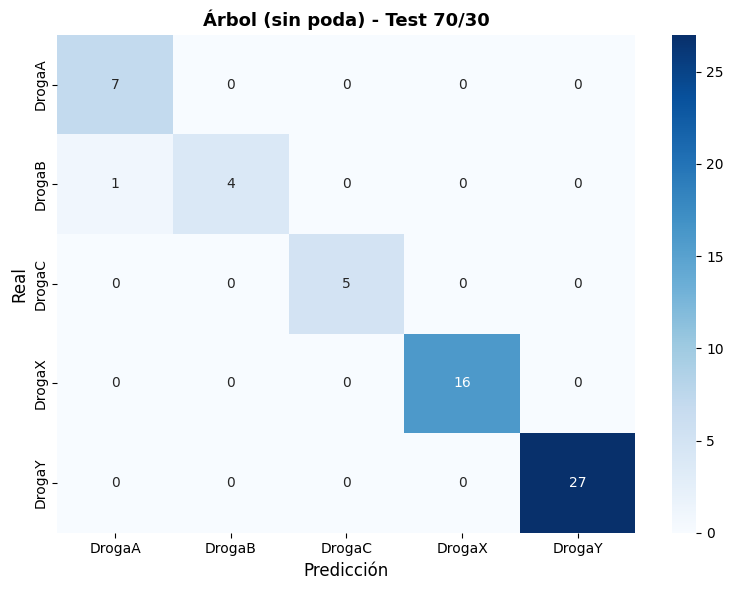

In [190]:
# 80/20
y_pred80 = best80.predict(X_te80)
print('\n=== Árbol (sin poda) - Test 80/20 ===')
print('Accuracy:', accuracy_score(y_te80, y_pred80))
print('Precision (macro):', precision_score(y_te80, y_pred80, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te80, y_pred80, average='macro', zero_division=0))
plot_conf_mat(y_te80, y_pred80, 'Árbol (sin poda) - Test 80/20')

# 70/30
y_pred70 = best70.predict(X_te70)
print('\n=== Árbol (sin poda) - Test 70/30 ===')
print('Accuracy:', accuracy_score(y_te70, y_pred70))
print('Precision (macro):', precision_score(y_te70, y_pred70, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te70, y_pred70, average='macro', zero_division=0))
plot_conf_mat(y_te70, y_pred70, 'Árbol (sin poda) - Test 70/30')

80/20: Accuracy del 97.5 % con F1 macro 0.93: el árbol supera con claridad el baseline. La matriz de confusión muestra predicciones correctas para todas las clases, salvo una instancia de DrogaB confundida con DrogaA; incluso las clases minoritarias (DrogaA/B/C) fueron reconocidas.

70/30: El desempeño en el split 70/30 es incluso ligeramente superior: accuracy 0.98 y métricas macro muy altas. La matriz de confusión es casi perfecta: todas las clases se predicen sin errores salvo una instancia de DrogaB clasificada como DrogaA. Esto confirma que el árbol generaliza bien aun con el set de test más grande.



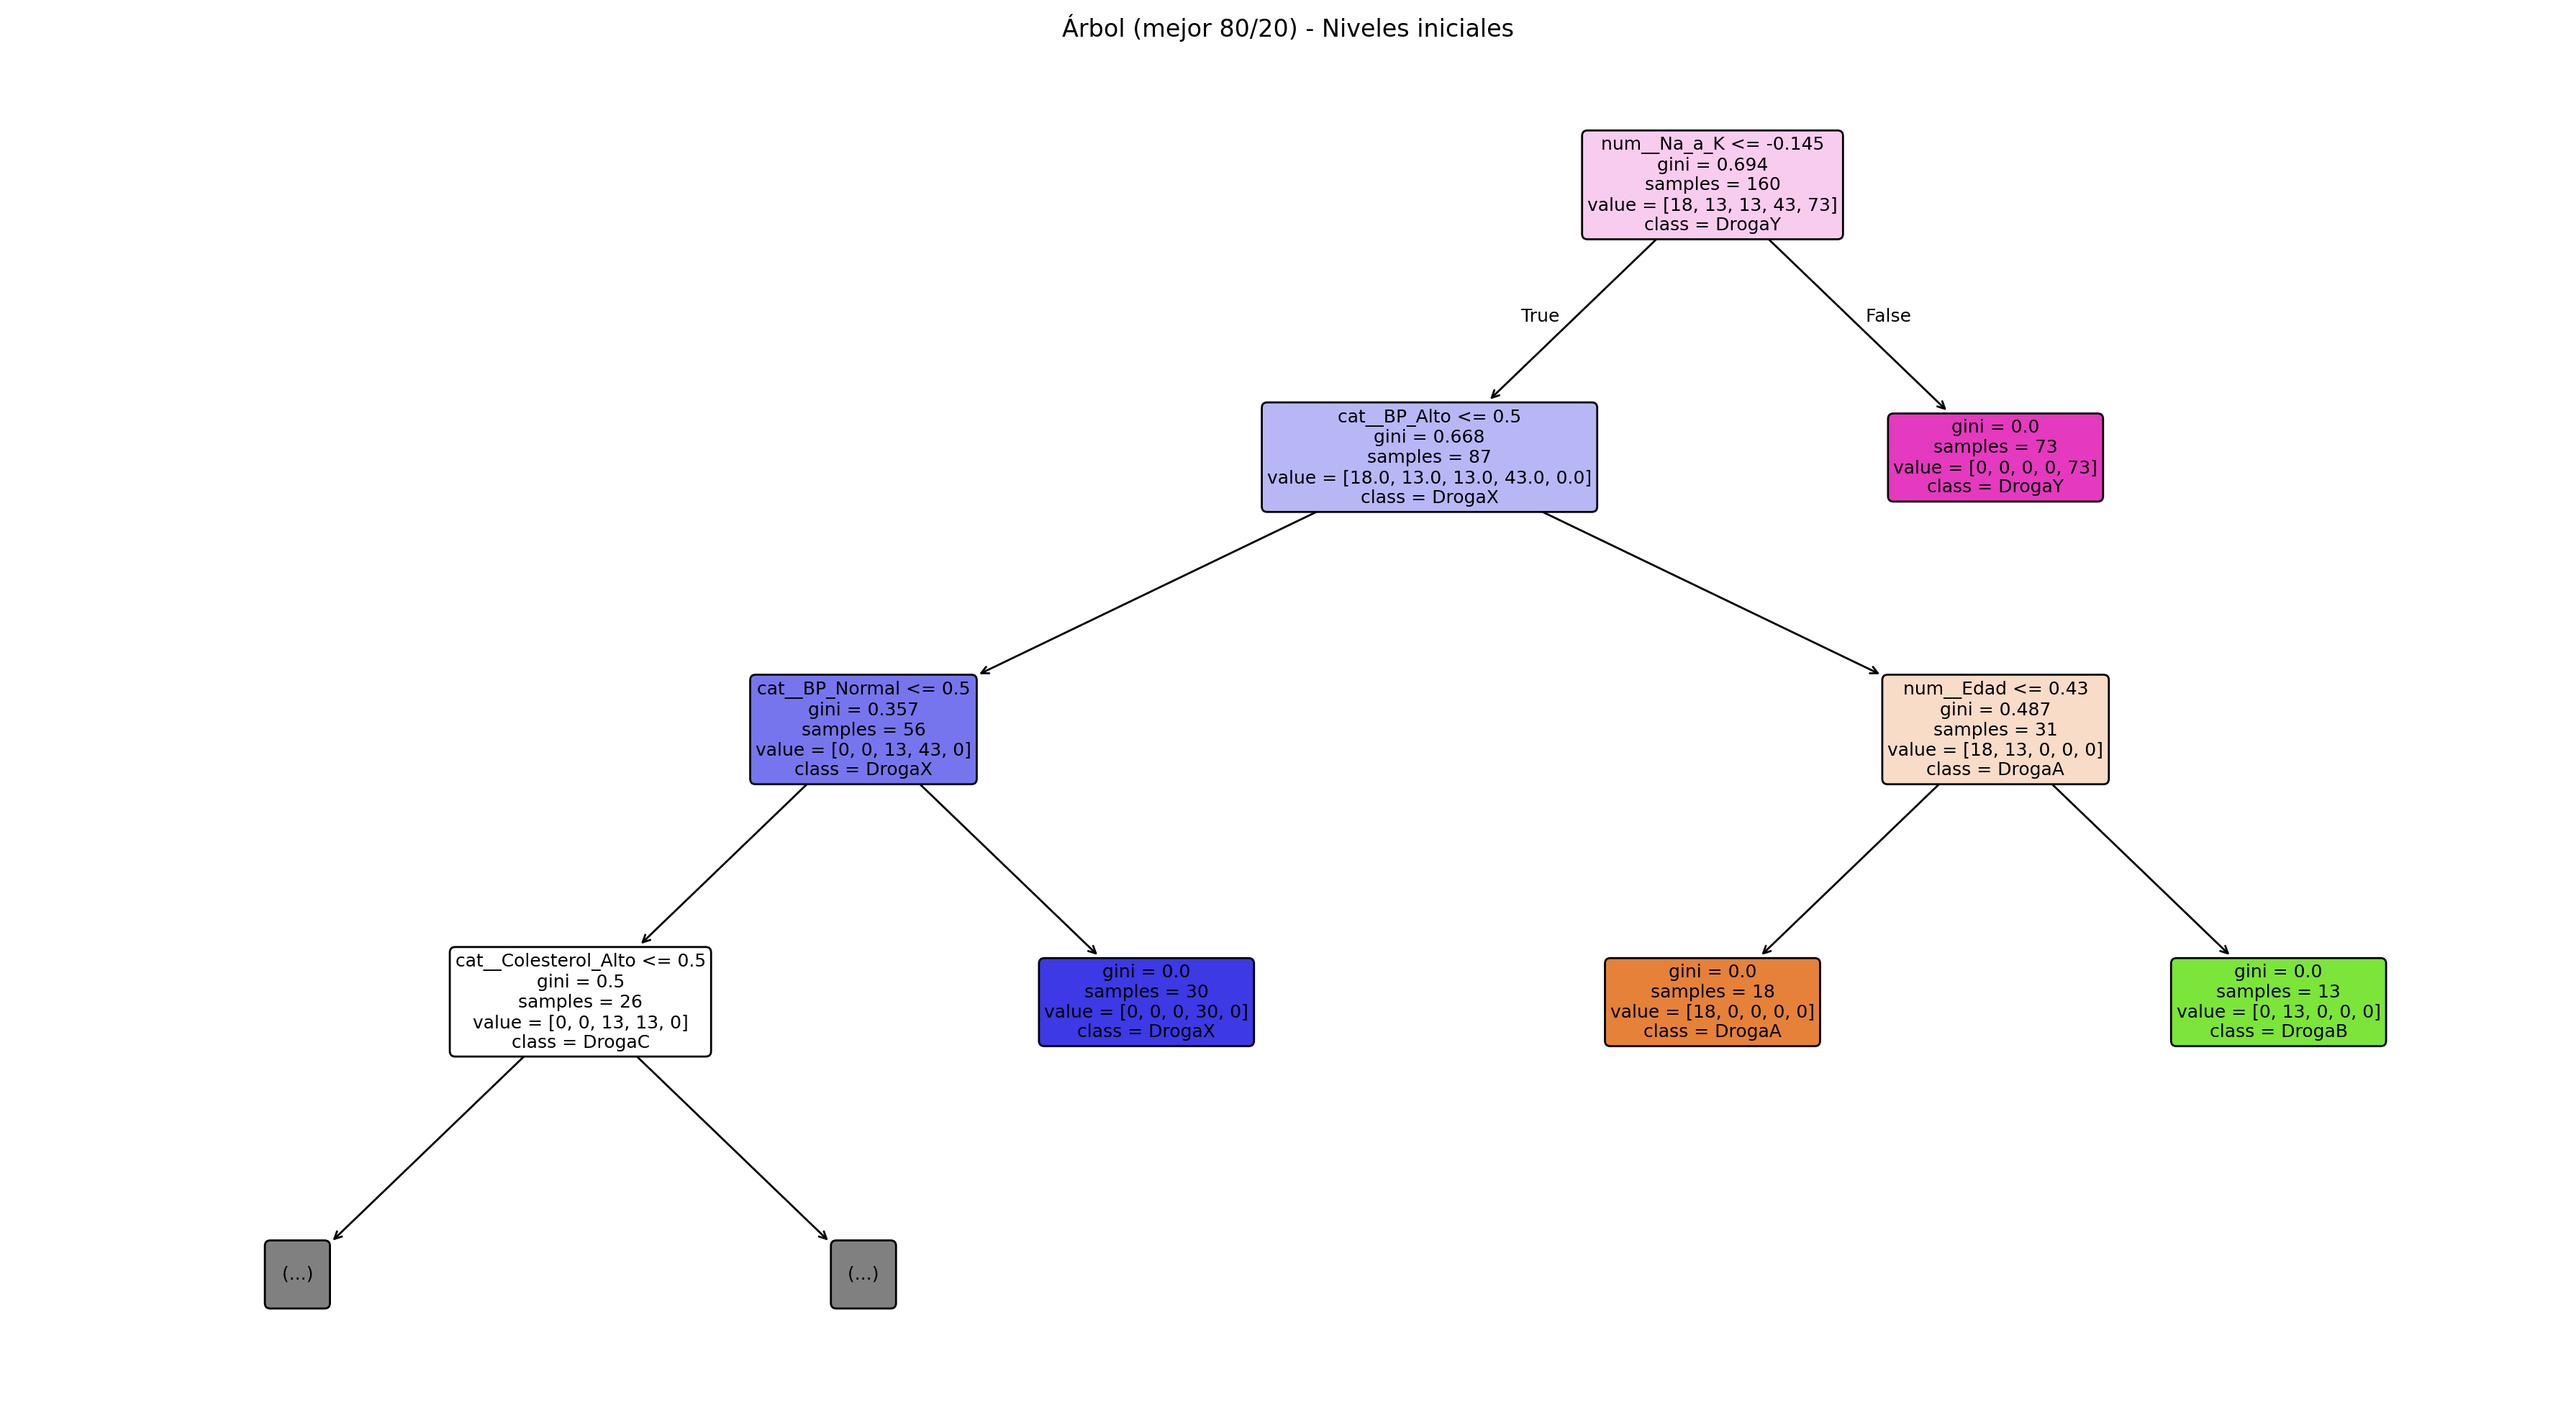

In [191]:
feat_names_80 = best80.named_steps['prep'].get_feature_names_out()
clf80 = best80.named_steps['model']

plt.figure(figsize=(18, 10), dpi=200)
plot_tree(
    clf80,
    feature_names=feat_names_80,
    class_names=sorted(y_tr80.unique()),
    filled=True, rounded=True,
    max_depth=3,    
    fontsize=9
)
plt.title('Árbol (mejor 80/20) - Niveles iniciales')
plt.tight_layout()
plt.show()

En este árbol (mejor configuración 80/20) se ve claramente la secuencia de decisiones: el primer corte lo hace el ratio Na_a_K, después interviene la presión arterial (BP) y recién en niveles más bajos aparecen colesterol y edad para distinguir las clases minoritarias. Esto confirma que Na_a_K es la variable más discriminante, seguida por BP, y que las demás ajustan los casos de frontera.

Alpha seleccionado (80/20): 0.0

 Árbol PODADO - Test 80/20
Accuracy: 0.975
Precision (macro): 0.9666666666666668
Recall (macro): 0.9333333333333332


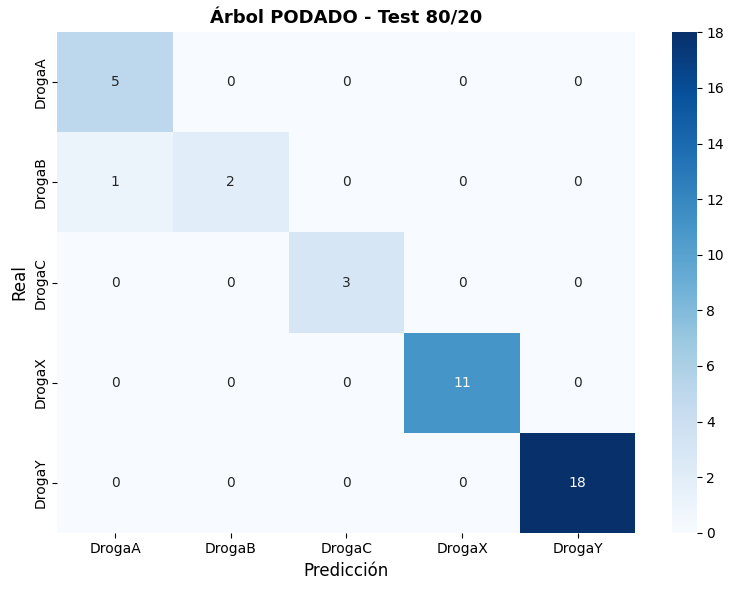

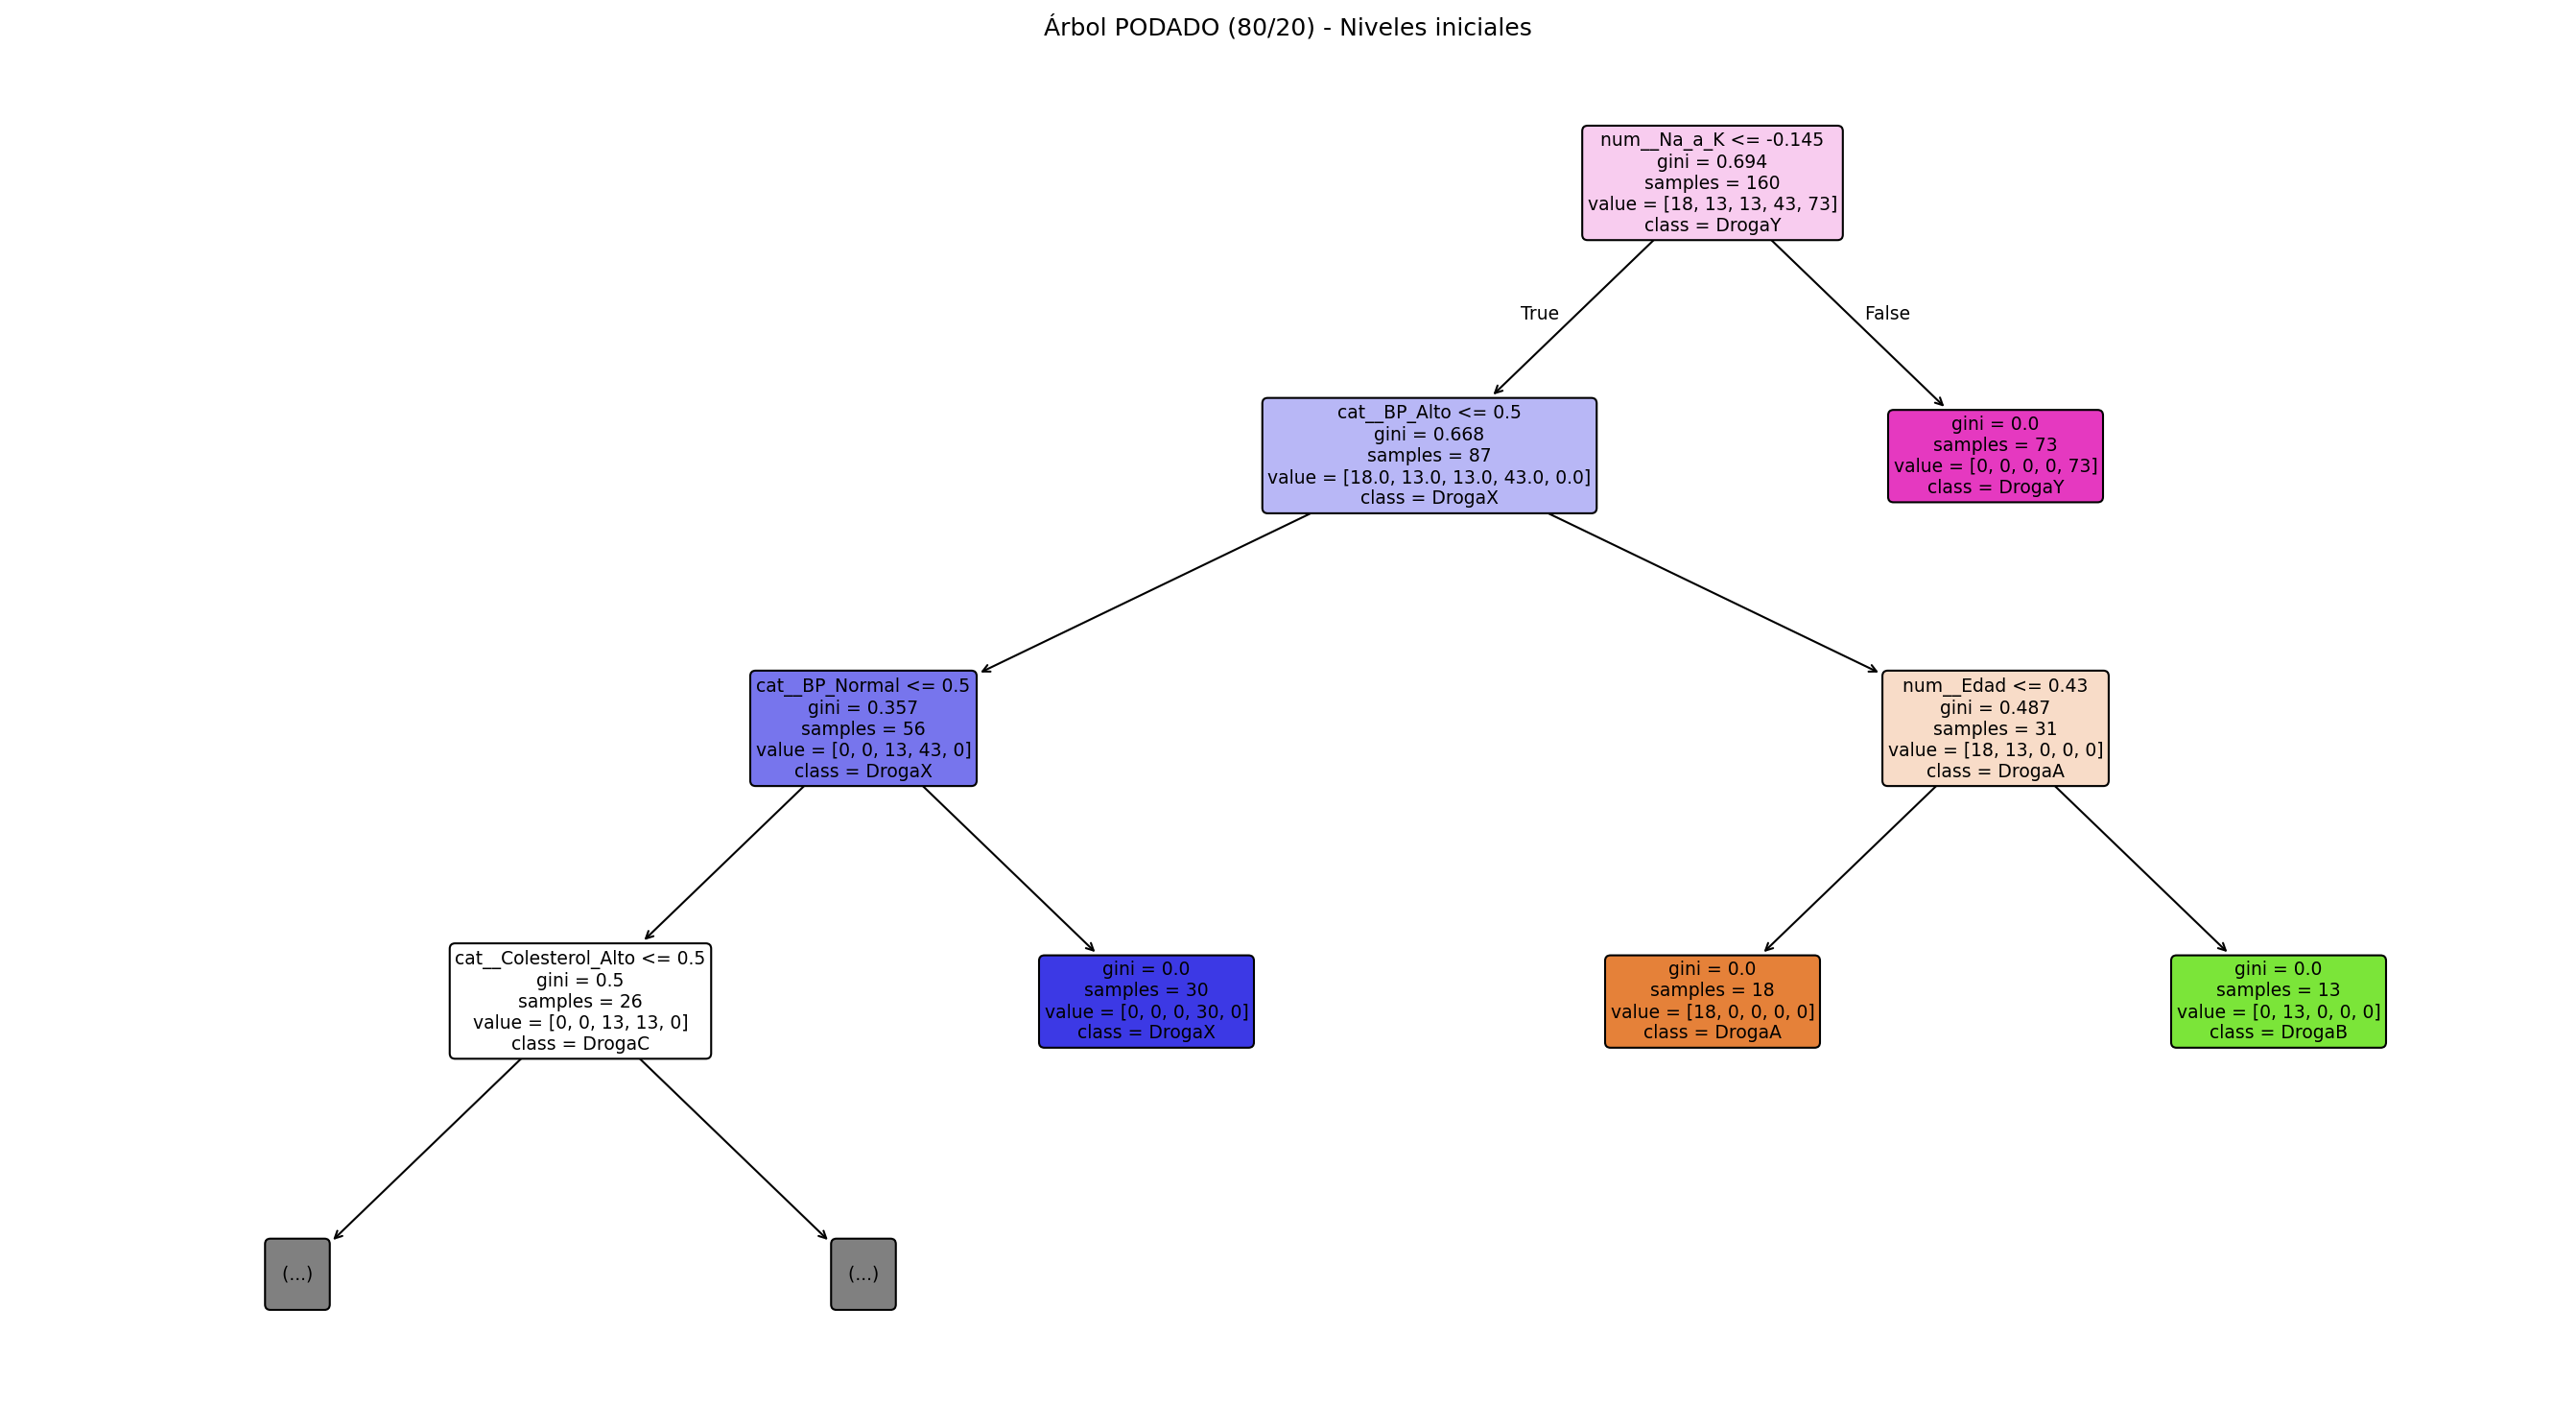

In [192]:
# Transformo el train (80/20) una sola vez para evaluar poda sin rehacer preprocesamiento
Xt_tr80 = best80.named_steps['prep'].transform(X_tr80)
y_tr80_arr = np.asarray(y_tr80)

# Camino de complejidad (alpha candidates)
tmp_tree = DecisionTreeClassifier(
    criterion=best80.named_steps['model'].criterion,
    max_depth=best80.named_steps['model'].max_depth,
    min_samples_leaf=best80.named_steps['model'].min_samples_leaf,
    min_samples_split=best80.named_steps['model'].min_samples_split,
    random_state=42
)
path = tmp_tree.cost_complexity_pruning_path(Xt_tr80, y_tr80_arr)
ccp_alphas = np.unique(np.round(path.ccp_alphas, 6))

# Selección de alpha por CV (f1_macro)
scores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion=tmp_tree.criterion,
        max_depth=tmp_tree.max_depth,
        min_samples_leaf=tmp_tree.min_samples_leaf,
        min_samples_split=tmp_tree.min_samples_split,
        ccp_alpha=alpha,
        random_state=42
    )
    cv_score = cross_val_score(clf, Xt_tr80, y_tr80_arr, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    scores.append(cv_score)

best_alpha = float(ccp_alphas[int(np.argmax(scores))])
print('Alpha seleccionado (80/20):', best_alpha)

# Entreno pipeline "podado": mismo preprocesamiento + ccp_alpha óptimo
pruned80 = Pipeline(steps=[
    ('prep', best80.named_steps['prep']),
    ('model', DecisionTreeClassifier(
        criterion=tmp_tree.criterion,
        max_depth=tmp_tree.max_depth,
        min_samples_leaf=tmp_tree.min_samples_leaf,
        min_samples_split=tmp_tree.min_samples_split,
        ccp_alpha=best_alpha,
        random_state=42
    ))
])
pruned80.fit(X_tr80, y_tr80)

# Evaluación podado 80/20
y_pred80_pruned = pruned80.predict(X_te80)
print('\n Árbol PODADO - Test 80/20')
print('Accuracy:', accuracy_score(y_te80, y_pred80_pruned))
print('Precision (macro):', precision_score(y_te80, y_pred80_pruned, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te80, y_pred80_pruned, average='macro', zero_division=0))
plot_conf_mat(y_te80, y_pred80_pruned, 'Árbol PODADO - Test 80/20')



# Graficamos solo UN ARBOL podado, tal cual lo solicitaban en el pdf 
#--------------------------------------------------------------------

feat_names_80 = pruned80.named_steps['prep'].get_feature_names_out()
plt.figure(figsize=(18, 10), dpi=150)
plot_tree(
    pruned80.named_steps['model'],
    feature_names=feat_names_80,
    class_names=sorted(y_tr80.unique()),
    filled=True, rounded=True,
    max_depth=3,
    fontsize=9
)
plt.title('Árbol PODADO (80/20) - Niveles iniciales')
plt.tight_layout()
plt.show()

Alpha seleccionado (70/30): 0.0

 Árbol PODADO - Test 70/30
Accuracy: 0.9833333333333333
Precision (macro): 0.975
Recall (macro): 0.96


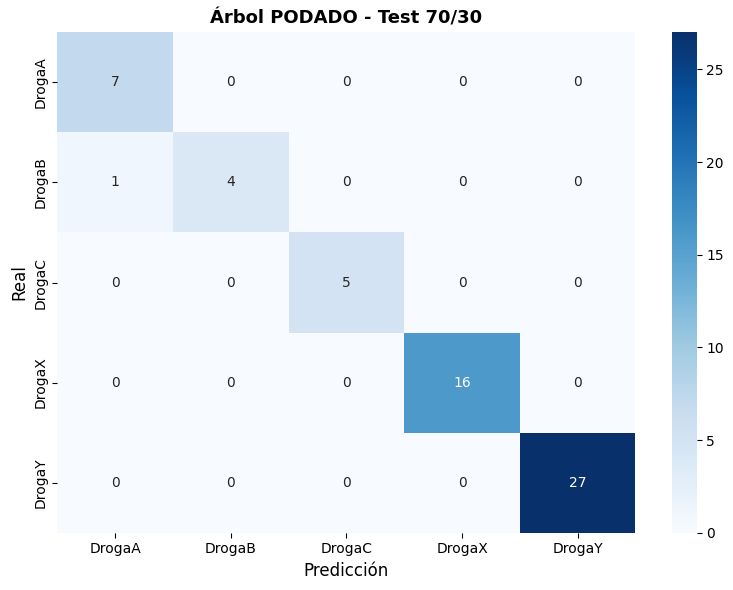

In [193]:
# Transformamos el train (70/30)
Xt_tr70 = best70.named_steps['prep'].transform(X_tr70)
y_tr70_arr = np.asarray(y_tr70)

tmp_tree70 = DecisionTreeClassifier(
    criterion=best70.named_steps['model'].criterion,
    max_depth=best70.named_steps['model'].max_depth,
    min_samples_leaf=best70.named_steps['model'].min_samples_leaf,
    min_samples_split=best70.named_steps['model'].min_samples_split,
    random_state=42
)
path70 = tmp_tree70.cost_complexity_pruning_path(Xt_tr70, y_tr70_arr)
ccp_alphas70 = np.unique(np.round(path70.ccp_alphas, 6))

scores70 = []
for alpha in ccp_alphas70:
    clf = DecisionTreeClassifier(
        criterion=tmp_tree70.criterion,
        max_depth=tmp_tree70.max_depth,
        min_samples_leaf=tmp_tree70.min_samples_leaf,
        min_samples_split=tmp_tree70.min_samples_split,
        ccp_alpha=alpha,
        random_state=42
    )
    cv_score = cross_val_score(clf, Xt_tr70, y_tr70_arr, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    scores70.append(cv_score)

best_alpha70 = float(ccp_alphas70[int(np.argmax(scores70))])
print('Alpha seleccionado (70/30):', best_alpha70)

pruned70 = Pipeline(steps=[
    ('prep', best70.named_steps['prep']),
    ('model', DecisionTreeClassifier(
        criterion=tmp_tree70.criterion,
        max_depth=tmp_tree70.max_depth,
        min_samples_leaf=tmp_tree70.min_samples_leaf,
        min_samples_split=tmp_tree70.min_samples_split,
        ccp_alpha=best_alpha70,
        random_state=42
    ))
])
pruned70.fit(X_tr70, y_tr70)

y_pred70_pruned = pruned70.predict(X_te70)
print('\n Árbol PODADO - Test 70/30')
print('Accuracy:', accuracy_score(y_te70, y_pred70_pruned))
print('Precision (macro):', precision_score(y_te70, y_pred70_pruned, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te70, y_pred70_pruned, average='macro', zero_division=0))
plot_conf_mat(y_te70, y_pred70_pruned, 'Árbol PODADO - Test 70/30')

### Conclusiones:

En ambos splits la poda no introdujo cambios: el camino de complejidad devolvió ccp_alpha = 0, por lo que el árbol podado coincide con el original y mantiene los mismos resultados (accuracy 0.98, precisión macro 0.97, recall macro entre 0.93 y 0.96). Las confusiones se reducen a un único caso de DrogaB→DrogaA en cada partición y el resto de las clases se predicen sin errores. Con esto concluimos que el árbol, tal como salió del grid search, ya estaba en su punto óptimo y no necesitaba poda adicional.

## Naive Bayes


In [ ]:
warnings.filterwarnings('ignore')

#Convertimos columnas categóricas en numéricas
cat_cols = ['Sexo', 'BP', 'Colesterol']

#80/20
X_train2_prep = X_tr80.copy()
X_test2_prep = X_te80.copy()
y_train2_prep = y_tr80.copy()
y_test2_prep = y_te80.copy()

cat_labels = [X_train2_prep[col].unique().tolist() for col in cat_cols]
enc = OrdinalEncoder(categories=cat_labels)
enc.fit(X_train2_prep[cat_cols])
X_train2_prep[cat_cols] = enc.transform(X_train2_prep[cat_cols])
X_test2_prep[cat_cols] = enc.transform(X_test2_prep[cat_cols])

### Decidimos discretizar las variables continuas de la siguiente forma:
**Variable Edad
Dividimos la edad en 5 categorías según etapas del ciclo de vida:**

(<18 años) Niño 
(18-35 años) Joven 
(35-55 años) Adulto 
(55-70 años) Senior 
(≥70 años) Anciano 

**Variable Na_a_K (Ratio Sodio/Potasio)
Discretizamos en 4 categorías basadas en rangos clínicos:**

Muy bajo (<10) muy bajo
Bajo (10-15) bajo
Normal (15-25) normal
Alto (≥25) alto

### Dataset 1 - División 80/20

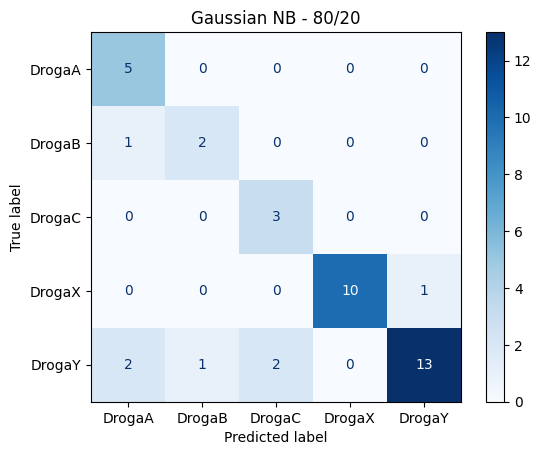

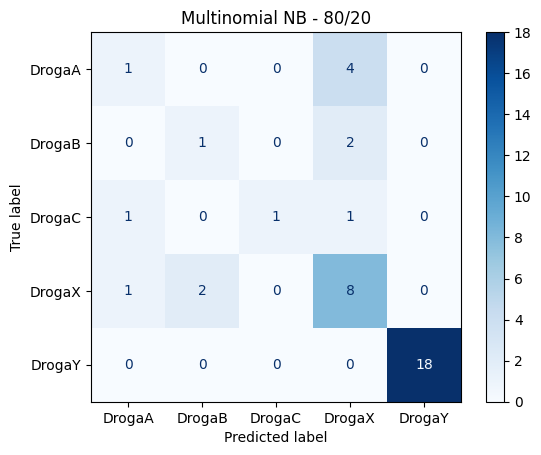

In [ ]:
#Definición y entrenamiento del modelo Gaussian
clf_GNB = GaussianNB()
clf_GNB.fit(X_train2_prep, y_train2_prep)

pred_GNB = clf_GNB.predict(X_test2_prep)

ConfusionMatrixDisplay.from_predictions(y_test2_prep, pred_GNB, cmap=plt.cm.Blues)
plt.title('Gaussian NB - 80/20')
plt.show()

#Discretizamos Edad en 5 categorías basadas en etapas de vida
X_train2_prep['edad_nino'] = (X_train2_prep['Edad'] < 18).astype(int)
X_train2_prep['edad_joven'] = ((X_train2_prep['Edad'] >= 18) & (X_train2_prep['Edad'] < 35)).astype(int)
X_train2_prep['edad_adulto'] = ((X_train2_prep['Edad'] >= 35) & (X_train2_prep['Edad'] < 55)).astype(int)
X_train2_prep['edad_senior'] = ((X_train2_prep['Edad'] >= 55) & (X_train2_prep['Edad'] < 70)).astype(int)
X_train2_prep['edad_anciano'] = (X_train2_prep['Edad'] >= 70).astype(int)

X_test2_prep['edad_nino'] = (X_test2_prep['Edad'] < 18).astype(int)
X_test2_prep['edad_joven'] = ((X_test2_prep['Edad'] >= 18) & (X_test2_prep['Edad'] < 35)).astype(int)
X_test2_prep['edad_adulto'] = ((X_test2_prep['Edad'] >= 35) & (X_test2_prep['Edad'] < 55)).astype(int)
X_test2_prep['edad_senior'] = ((X_test2_prep['Edad'] >= 55) & (X_test2_prep['Edad'] < 70)).astype(int)
X_test2_prep['edad_anciano'] = (X_test2_prep['Edad'] >= 70).astype(int)

#Discretizamos Na_a_K en 4 categorías basadas en rangos clínicos
X_train2_prep['NaK_muy_bajo'] = (X_train2_prep['Na_a_K'] < 10).astype(int)
X_train2_prep['NaK_bajo'] = ((X_train2_prep['Na_a_K'] >= 10) & (X_train2_prep['Na_a_K'] < 15)).astype(int)
X_train2_prep['NaK_normal'] = ((X_train2_prep['Na_a_K'] >= 15) & (X_train2_prep['Na_a_K'] < 25)).astype(int)
X_train2_prep['NaK_alto'] = (X_train2_prep['Na_a_K'] >= 25).astype(int)

X_test2_prep['NaK_muy_bajo'] = (X_test2_prep['Na_a_K'] < 10).astype(int)
X_test2_prep['NaK_bajo'] = ((X_test2_prep['Na_a_K'] >= 10) & (X_test2_prep['Na_a_K'] < 15)).astype(int)
X_test2_prep['NaK_normal'] = ((X_test2_prep['Na_a_K'] >= 15) & (X_test2_prep['Na_a_K'] < 25)).astype(int)
X_test2_prep['NaK_alto'] = (X_test2_prep['Na_a_K'] >= 25).astype(int)

clf_MNB = MultinomialNB()
clf_MNB.fit(X_train2_prep, y_train2_prep)

pred_MNB = clf_MNB.predict(X_test2_prep)

ConfusionMatrixDisplay.from_predictions(y_test2_prep, pred_MNB, cmap=plt.cm.Blues)
plt.title('Multinomial NB - 80/20')
plt.show()

### Dataset 2 (70/30)

In [196]:
#70/30
X_train3_prep = X_tr70.copy()
X_test3_prep = X_te70.copy()
y_train3_prep = y_tr70.copy()
y_test3_prep = y_te70.copy()

X_train3_prep[cat_cols] = enc.transform(X_train3_prep[cat_cols])
X_test3_prep[cat_cols] = enc.transform(X_test3_prep[cat_cols])

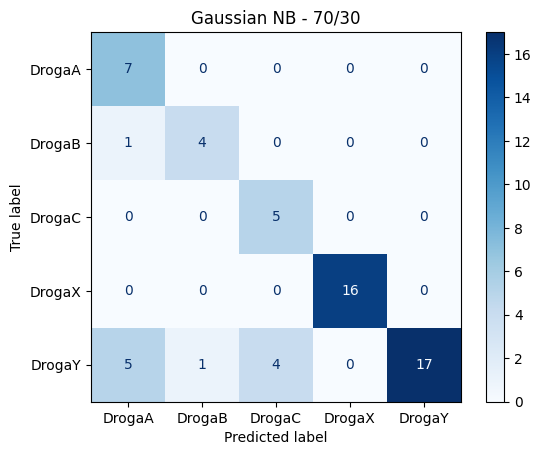

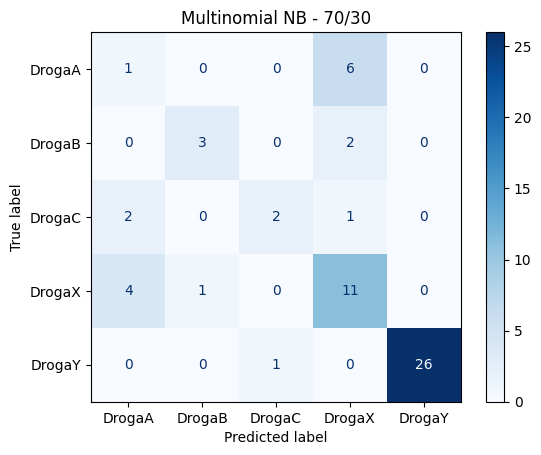

In [ ]:
#Definición y entrenamiento del modelo Gaussian
clf_GNB2 = GaussianNB()
clf_GNB2.fit(X_train3_prep, y_train3_prep)

pred_GNB2 = clf_GNB2.predict(X_test3_prep)

ConfusionMatrixDisplay.from_predictions(y_test3_prep, pred_GNB2, cmap=plt.cm.Blues)
plt.title('Gaussian NB - 70/30')
plt.show()

#Discretizamos Edad en 5 categorías basadas en etapas de vida
X_train3_prep['edad_nino'] = (X_train3_prep['Edad'] < 18).astype(int)
X_train3_prep['edad_joven'] = ((X_train3_prep['Edad'] >= 18) & (X_train3_prep['Edad'] < 35)).astype(int)
X_train3_prep['edad_adulto'] = ((X_train3_prep['Edad'] >= 35) & (X_train3_prep['Edad'] < 55)).astype(int)
X_train3_prep['edad_senior'] = ((X_train3_prep['Edad'] >= 55) & (X_train3_prep['Edad'] < 70)).astype(int)
X_train3_prep['edad_anciano'] = (X_train3_prep['Edad'] >= 70).astype(int)

X_test3_prep['edad_nino'] = (X_test3_prep['Edad'] < 18).astype(int)
X_test3_prep['edad_joven'] = ((X_test3_prep['Edad'] >= 18) & (X_test3_prep['Edad'] < 35)).astype(int)
X_test3_prep['edad_adulto'] = ((X_test3_prep['Edad'] >= 35) & (X_test3_prep['Edad'] < 55)).astype(int)
X_test3_prep['edad_senior'] = ((X_test3_prep['Edad'] >= 55) & (X_test3_prep['Edad'] < 70)).astype(int)
X_test3_prep['edad_anciano'] = (X_test3_prep['Edad'] >= 70).astype(int)

#Discretizamos Na_a_K en 4 categorías basadas en rangos clínicos
X_train3_prep['NaK_muy_bajo'] = (X_train3_prep['Na_a_K'] < 10).astype(int)
X_train3_prep['NaK_bajo'] = ((X_train3_prep['Na_a_K'] >= 10) & (X_train3_prep['Na_a_K'] < 15)).astype(int)
X_train3_prep['NaK_normal'] = ((X_train3_prep['Na_a_K'] >= 15) & (X_train3_prep['Na_a_K'] < 25)).astype(int)
X_train3_prep['NaK_alto'] = (X_train3_prep['Na_a_K'] >= 25).astype(int)

X_test3_prep['NaK_muy_bajo'] = (X_test3_prep['Na_a_K'] < 10).astype(int)
X_test3_prep['NaK_bajo'] = ((X_test3_prep['Na_a_K'] >= 10) & (X_test3_prep['Na_a_K'] < 15)).astype(int)
X_test3_prep['NaK_normal'] = ((X_test3_prep['Na_a_K'] >= 15) & (X_test3_prep['Na_a_K'] < 25)).astype(int)
X_test3_prep['NaK_alto'] = (X_test3_prep['Na_a_K'] >= 25).astype(int)

clf_MNB2 = MultinomialNB()
clf_MNB2.fit(X_train3_prep, y_train3_prep)

pred_MNB2 = clf_MNB2.predict(X_test3_prep)

ConfusionMatrixDisplay.from_predictions(y_test3_prep, pred_MNB2, cmap=plt.cm.Blues)
plt.title('Multinomial NB - 70/30')
plt.show()

### Métricas


In [198]:
#GNB
precision_GNB = precision_score(y_test2_prep, pred_GNB, average='macro')
accuracy_GNB = accuracy_score(y_test2_prep, pred_GNB)
recall_GNB = recall_score(y_test2_prep, pred_GNB, average='macro')

precision_GNB2 = precision_score(y_test3_prep, pred_GNB2, average='macro')
accuracy_GNB2 = accuracy_score(y_test3_prep, pred_GNB2)
recall_GNB2 = recall_score(y_test3_prep, pred_GNB2, average='macro')

#MNB
precision_MNB = precision_score(y_test2_prep, pred_MNB, average='macro')
accuracy_MNB = accuracy_score(y_test2_prep, pred_MNB)
recall_MNB = recall_score(y_test2_prep, pred_MNB, average='macro')

precision_MNB2 = precision_score(y_test3_prep, pred_MNB2, average='macro')
accuracy_MNB2 = accuracy_score(y_test3_prep, pred_MNB2)
recall_MNB2 = recall_score(y_test3_prep, pred_MNB2, average='macro')

#Tabla con métricas
metricas = pd.DataFrame({
    'Classifier': ['GaussianNB', 'GaussianNB', 'MultinomialNB', 'MultinomialNB'],
    'Split': ['80/20', '70/30', '80/20', '70/30'],
    'Precision': [precision_GNB, precision_GNB2, precision_MNB, precision_MNB2],
    'Accuracy': [accuracy_GNB, accuracy_GNB2, accuracy_MNB, accuracy_MNB2],
    'Recall': [recall_GNB, recall_GNB2, recall_MNB, recall_MNB2]
})

print(metricas)

      Classifier  Split  Precision  Accuracy    Recall
0     GaussianNB  80/20   0.764048  0.825000  0.859596
1     GaussianNB  70/30   0.778803  0.816667  0.885926
2  MultinomialNB  80/20   0.640000  0.725000  0.518788
3  MultinomialNB  70/30   0.621905  0.716667  0.558664


## KNN


### Preprocesamiento


In [213]:
#Convertimos columnas categóricas en numéricas
cat_cols = ['Sexo', 'BP', 'Colesterol']

#80/20
X_train2 = X_tr80.copy()
X_test2 = X_te80.copy()
y_train2 = y_tr80.copy()
y_test2 = y_te80.copy()

cat_labels = [X_train2[col].unique().tolist() for col in cat_cols]
enc = OrdinalEncoder(categories=cat_labels)
enc.fit(X_train2[cat_cols])
X_train2[cat_cols] = enc.transform(X_train2[cat_cols])
X_test2[cat_cols] = enc.transform(X_test2[cat_cols])

#70/30
X_train3 = X_tr70.copy()
X_test3 = X_te70.copy()
y_train3 = y_tr70.copy()
y_test3 = y_te70.copy()

X_train3[cat_cols] = enc.transform(X_train3[cat_cols])
X_test3[cat_cols] = enc.transform(X_test3[cat_cols])

#Escalado de variables numéricas
num_cols = ['Edad', 'Na_a_K']

scaler = StandardScaler()
scaler.fit(X_train2[num_cols])
X_train2[num_cols] = scaler.transform(X_train2[num_cols])
X_test2[num_cols] = scaler.transform(X_test2[num_cols])

X_train3[num_cols] = scaler.transform(X_train3[num_cols])
X_test3[num_cols] = scaler.transform(X_test3[num_cols])

### Gráfico de precición según valor de K - Dataset 1 (80/20)

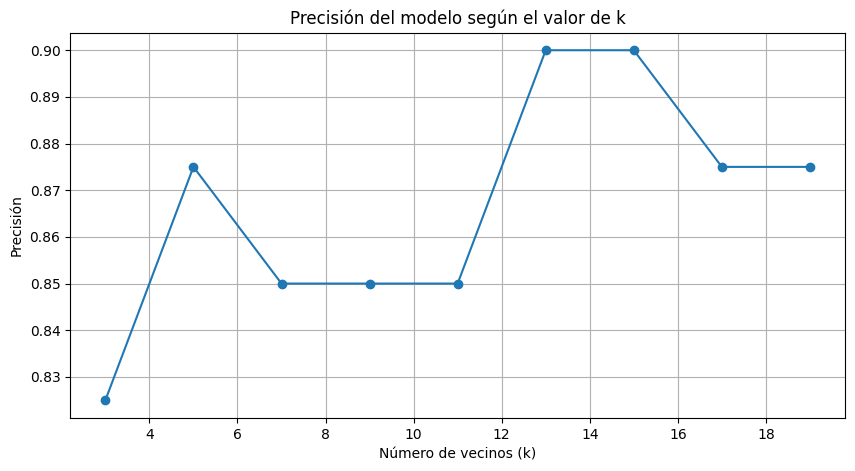

In [223]:
k_values = range(3, 21, 2) 
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train2, y_train2)
    predicciones = knn.predict(X_test2)
    accuracies.append(accuracy_score(y_test2, predicciones))

plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.title('Precisión del modelo según el valor de k')
plt.grid(True)
plt.show()

Este gráfico nos indica que el valor óptimo de K es 13, 14 o 15 (luego de probar los 3 valores, elegimos 13 ya es el que más precisión dió)

### Dataset 1 - División 80/20

In [225]:
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train2, y_train2)

predicciones = knn.predict(X_test2)

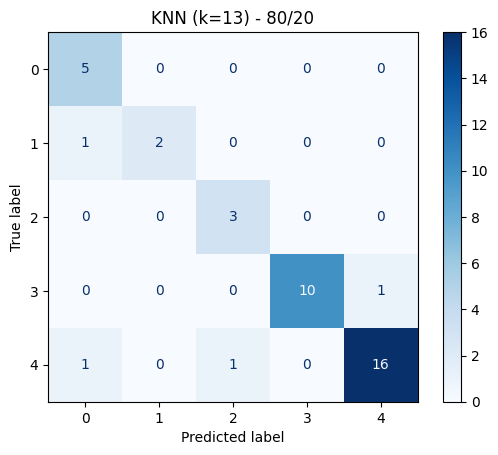

Precisión del modelo: 0.90

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.71      1.00      0.83         5
      DrogaB       1.00      0.67      0.80         3
      DrogaC       0.75      1.00      0.86         3
      DrogaX       1.00      0.91      0.95        11
      DrogaY       0.94      0.89      0.91        18

    accuracy                           0.90        40
   macro avg       0.88      0.89      0.87        40
weighted avg       0.92      0.90      0.90        40



In [226]:
cm_knn = confusion_matrix(y_test2, predicciones)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(cmap=plt.cm.Blues)
plt.title('KNN (k=13) - 80/20')
plt.show()

accuracy = accuracy_score(y_test2, predicciones)
print(f'Precisión del modelo: {accuracy:.2f}')

print('\nInforme de Clasificación:')
print(classification_report(y_test2, predicciones))

In [ ]:
#Definir los parámetros a ajustar
parametros_grid = {'n_neighbors':  range(1, 50, 10),
                   'p':[1,2],
                   'weights': ['uniform', 'distance'] }

grid_search = GridSearchCV(estimator = knn,
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train2, y_train2)

print('\nMejores parámetros encontrados:')
print(grid_search.best_params_)
print(f'Mejor score (validación cruzada): {grid_search.best_score_:.4f}')


Mejores parámetros encontrados:
{'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Mejor score (validación cruzada): 0.9375


### Optimización del dataset 1 (80/20)

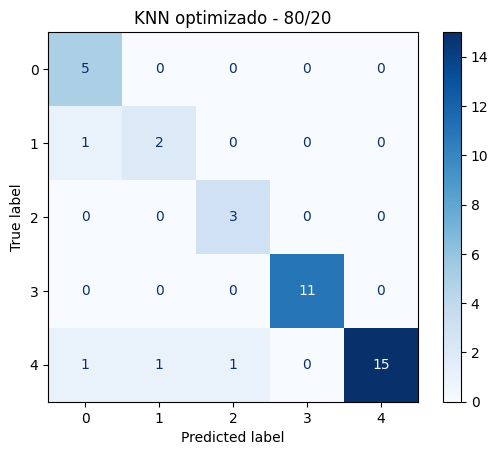


Precisión del modelo optimizado: 0.9000
Precision (macro): 0.8262
Recall (macro): 0.9000

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.71      1.00      0.83         5
      DrogaB       0.67      0.67      0.67         3
      DrogaC       0.75      1.00      0.86         3
      DrogaX       1.00      1.00      1.00        11
      DrogaY       1.00      0.83      0.91        18

    accuracy                           0.90        40
   macro avg       0.83      0.90      0.85        40
weighted avg       0.92      0.90      0.90        40



In [ ]:
#Entrenamos con los mejores parámetros
mejor_knn = grid_search.best_estimator_
predictions_best = mejor_knn.predict(X_test2)

cm_best = confusion_matrix(y_test2, predictions_best)
ConfusionMatrixDisplay(confusion_matrix=cm_best).plot(cmap=plt.cm.Blues)
plt.title(f'KNN optimizado - 80/20')
plt.show()

accuracy_best = accuracy_score(y_test2, predictions_best)
precision_best = precision_score(y_test2, predictions_best, average='macro')
recall_best = recall_score(y_test2, predictions_best, average='macro')

print(f'\nPrecisión del modelo optimizado: {accuracy_best:.4f}')
print(f'Precision (macro): {precision_best:.4f}')
print(f'Recall (macro): {recall_best:.4f}')

print('\nInforme de Clasificación:')
print(classification_report(y_test2, predictions_best))

### Gráfico de precición según valor de K - Dataset 2 (70/30)

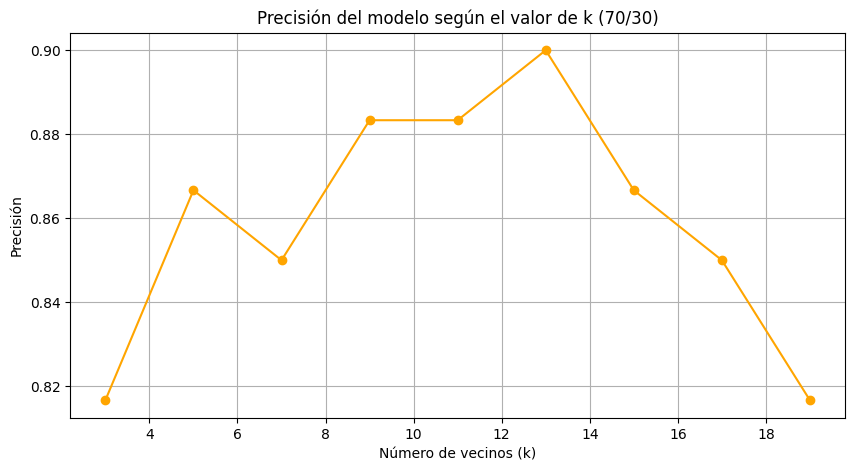

In [219]:
valores_k = range(3, 21, 2)
accuracies_70 = []

for k in valores_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train3, y_train3)
    predictions = knn.predict(X_test3)
    accuracies_70.append(accuracy_score(y_test3, predictions))

plt.figure(figsize=(10,5))
plt.plot(valores_k, accuracies_70, marker='o', color='orange')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.title('Precisión del modelo según el valor de k (70/30)')
plt.grid(True)
plt.show()

Este gráfico nos muestra que el valor óptimo de K es 13

In [220]:
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train3, y_train3)

predictions = knn.predict(X_test3)

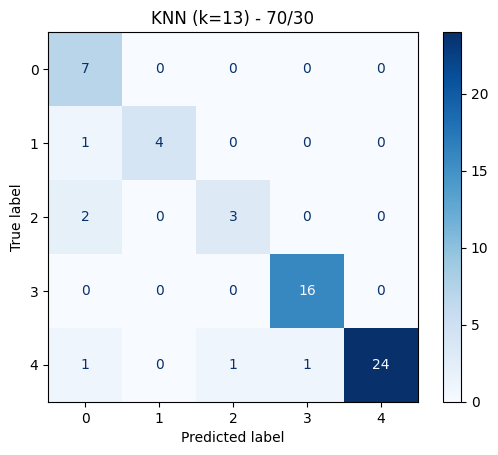

Precisión del modelo: 0.90

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.64      1.00      0.78         7
      DrogaB       1.00      0.80      0.89         5
      DrogaC       0.75      0.60      0.67         5
      DrogaX       0.94      1.00      0.97        16
      DrogaY       1.00      0.89      0.94        27

    accuracy                           0.90        60
   macro avg       0.87      0.86      0.85        60
weighted avg       0.92      0.90      0.90        60



In [221]:
cm_knn = confusion_matrix(y_test3, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot(cmap=plt.cm.Blues)
plt.title('KNN (k=13) - 70/30')
plt.show()

accuracy = accuracy_score(y_test3, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

print('\nInforme de Clasificación:')
print(classification_report(y_test3, predictions))

### Optimización del dataset 2 (70/30) 

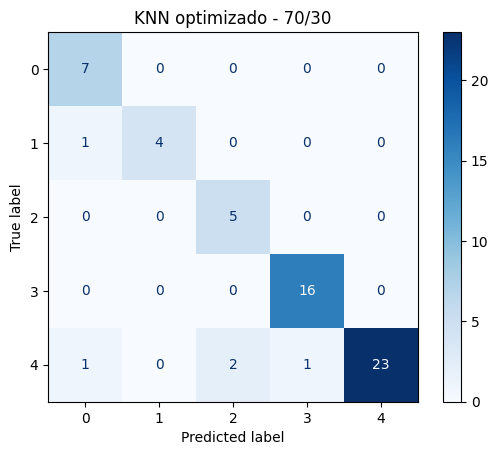


Precisión del modelo optimizado (70/30): 0.9167
Precision (macro): 0.8866
Recall (macro): 0.9304

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.78      1.00      0.88         7
      DrogaB       1.00      0.80      0.89         5
      DrogaC       0.71      1.00      0.83         5
      DrogaX       0.94      1.00      0.97        16
      DrogaY       1.00      0.85      0.92        27

    accuracy                           0.92        60
   macro avg       0.89      0.93      0.90        60
weighted avg       0.93      0.92      0.92        60



In [222]:
#Entrenamos con los mejores parámetros
mejor_knn_70 = KNeighborsClassifier(**grid_search.best_params_)
mejor_knn_70.fit(X_train3, y_train3)
prediccciones_70 = mejor_knn_70.predict(X_test3)

cm_70 = confusion_matrix(y_test3, prediccciones_70)
ConfusionMatrixDisplay(confusion_matrix=cm_70).plot(cmap=plt.cm.Blues)
plt.title(f'KNN optimizado - 70/30')
plt.show()

accuracy_70 = accuracy_score(y_test3, prediccciones_70)
precision_70 = precision_score(y_test3, prediccciones_70, average='macro')
recall_70 = recall_score(y_test3, prediccciones_70, average='macro')

print(f'\nPrecisión del modelo optimizado (70/30): {accuracy_70:.4f}')
print(f'Precision (macro): {precision_70:.4f}')
print(f'Recall (macro): {recall_70:.4f}')

print('\nInforme de Clasificación:')
print(classification_report(y_test3, prediccciones_70))